In [1]:
# 패키지 임포트
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
from tensorflow.losses import huber_loss

Using TensorFlow backend.


In [0]:
# 파라미터 준비
NUM_EPISODES = 500 # 에피소드 수
MAX_STEPS = 200 # 최대 스텝 수
GAMMA = 0.99 # 시간 할인율
WARMUP = 10 # 초기화 시 조작하지 않을 스텝 수

# 탐색 파라미터
E_START = 1.0 # ε 초기값
E_STOP = 0.01 # ε 최종값
E_DECAY_RATE = 0.001 # ε 감쇠율

# 메모리 파라미터
MEMORY_SIZE = 10000 # 경험 메모리 사이즈
BATCH_SIZE = 32 # 배치 사이즈

In [0]:
# 행동 가치 함수 저의
class QNetwork:
    # 초기화
    def __init__(self, state_size, action_size):
        # 모델 생성
        self.model = Sequential()
        self.model.add(Dense(16, activation='relu', input_dim=state_size))
        self.model.add(Dense(16, activation='relu'))
        self.model.add(Dense(16, activation='relu'))
        self.model.add(Dense(action_size, activation='linear'))
        
        # 모델 컴파일
        self.model.compile(loss=huber_loss, optimizer=Adam(lr=0.001))

In [0]:
# 경험 메모리 정의
class Memory():
    # 초기화
    def __init__(self, memory_size):
        self.buffer = deque(maxlen=memory_size)

    # 경험 추가
    def add(self, experience):
        self.buffer.append(experience)

    # 배치 사이즈 만큼 경험을 랜덤하게 취득
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[i] for i in idx]
    
    # 경험 메모리 사이즈
    def __len__(self):
        return len(self.buffer)

In [0]:
# 환경 생성
env = gym.make('CartPole-v0')
state_size = env.observation_space.shape[0] # 행동 수
action_size = env.action_space.n # 상태 수

# 메인 네트워크 생성
main_qn = QNetwork(state_size, action_size)

# 대상 네트워크 생성
target_qn = QNetwork(state_size, action_size)

# 경험 메모리 생성
memory = Memory(MEMORY_SIZE)

In [7]:
# 학습 개시

# 환경 초기화
state = env.reset()
state = np.reshape(state, [1, state_size])

# 에피소드 수 만큼 메피소드 반복
total_step = 0 # 총 스텝 수
success_count = 0 # 성공 수
for episode in range(1, NUM_EPISODES+1):
    step = 0 # 스텝 수
    
    # 대상 네트워크 갱신
    target_qn.model.set_weights(main_qn.model.get_weights())
    
    # 1 에피소드 루프
    for _ in range(1, MAX_STEPS+1):
        step += 1
        total_step += 1

        # ε를 감소시킴
        epsilon = E_STOP + (E_START - E_STOP)*np.exp(-E_DECAY_RATE*total_step)
        
        # 랜덤하게 생동 선택
        if epsilon > np.random.rand():
            action = env.action_space.sample()
        # 행동 가치 함수에 따른 행동 선택
        else:
            action = np.argmax(main_qn.model.predict(state)[0])

        # 행동에 맞추어 상태와 보상을 얻음
        next_state, _, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])

        # 에피소드 완료 시
        if done:
            # 보상 지정
            if step >= 190:
                success_count += 1
                reward = 1
            else:
                success_count = 0
                reward = 0
            
            # 다음 상태에 상태 없음을 대입
            next_state = np.zeros(state.shape)
            
            # 경험 추가
            if step > WARMUP:
                memory.add((state, action, reward, next_state))                        
        # 에피소드 미완료 시
        else:
            # 보상 지정
            reward = 0
                
            # 경험 추가
            if step > WARMUP:
                memory.add((state, action, reward, next_state))
            
            # 상태에 다음 상태 대입
            state = next_state

        # 행동 평가 함수 갱신
        if len(memory) >= BATCH_SIZE:
            # 뉴럴 네트워크의 입력과 출력 준비
            inputs = np.zeros((BATCH_SIZE, 4)) # 입력(상태)
            targets = np.zeros((BATCH_SIZE, 2)) # 출력(행동별 가치)

            # 배치 사이즈 만큼 경험을 랜덤하게 선택
            minibatch = memory.sample(BATCH_SIZE)
            
            # 뉴럴 네트워크 입력과 출력 생성
            for i, (state_b, action_b, reward_b, next_state_b) in enumerate(minibatch):
                
                # 입력 상태 지정
                inputs[i] = state_b
                
                # 선택한 행동의 가치 계산
                if not (next_state_b == np.zeros(state_b.shape)).all(axis=1):
                    target = reward_b + GAMMA * np.amax(target_qn.model.predict(next_state_b)[0])
                else:
                    target = reward_b

                # 출력에 행동 별 가치를 지정
                targets[i] = main_qn.model.predict(state_b)
                targets[i][action_b] = target # 선택한 행동의 가치

            # 행동 가치 함수 갱신
            main_qn.model.fit(inputs, targets, epochs=1, verbose=0)
        
        # 에피소드 완료 시
        if done:
            # 에피소드 루프 이탈
            break
           
    # 에피소드 완료 시 로그 표시
    print('에피소드: {}, 스텝 수: {}, epsilon: {:.4f}'.format(episode, step, epsilon))

    # 5회 연송 성공으로 학습 완료
    if success_count >= 5:
        break

    # 환경 초기화
    state = env.reset()
    state = np.reshape(state, [1, state_size])        

W0727 20:40:58.296272 139828230539136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0727 20:40:58.297949 139828230539136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



에피소드: 1, 스텝 수: 13, epsilon: 0.9872
에피소드: 2, 스텝 수: 14, epsilon: 0.9736
에피소드: 3, 스텝 수: 19, epsilon: 0.9555
에피소드: 4, 스텝 수: 10, epsilon: 0.9461
에피소드: 5, 스텝 수: 92, epsilon: 0.8638
에피소드: 6, 스텝 수: 32, epsilon: 0.8369
에피소드: 7, 스텝 수: 30, epsilon: 0.8125
에피소드: 8, 스텝 수: 9, epsilon: 0.8053
에피소드: 9, 스텝 수: 20, epsilon: 0.7895
에피소드: 10, 스텝 수: 9, epsilon: 0.7826
에피소드: 11, 스텝 수: 22, epsilon: 0.7657
에피소드: 12, 스텝 수: 14, epsilon: 0.7552
에피소드: 13, 스텝 수: 20, epsilon: 0.7405
에피소드: 14, 스텝 수: 12, epsilon: 0.7318
에피소드: 15, 스텝 수: 12, epsilon: 0.7232
에피소드: 16, 스텝 수: 20, epsilon: 0.7090
에피소드: 17, 스텝 수: 13, epsilon: 0.7000
에피소드: 18, 스텝 수: 15, epsilon: 0.6897
에피소드: 19, 스텝 수: 14, epsilon: 0.6803
에피소드: 20, 스텝 수: 12, epsilon: 0.6723
에피소드: 21, 스텝 수: 34, epsilon: 0.6502
에피소드: 22, 스텝 수: 72, epsilon: 0.6057
에피소드: 23, 스텝 수: 46, epsilon: 0.5789
에피소드: 24, 스텝 수: 60, epsilon: 0.5458
에피소드: 25, 스텝 수: 45, epsilon: 0.5222
에피소드: 26, 스텝 수: 60, epsilon: 0.4924
에피소드: 27, 스텝 수: 73, epsilon: 0.4584
에피소드: 28, 스텝 수: 46, epsilon: 0.4382
에피소

In [0]:
# 디스플레이 설정 인스톨
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg x11-utils > /dev/null
!pip install pyglet==1.3.2
!pip install pyopengl
!pip install pyvirtualdisplay

# 디스플레이 설정 적용
from pyvirtualdisplay import Display
import os
disp = Display(visible=0, size=(1024, 768))
disp.start()
os.environ['DISPLAY'] = ':' + str(disp.display) + '.' + str(disp.screen)

In [0]:
# 평가
frames = [] # 애니메이션 프레임

# 환경 초기화
state = env.reset()
state = np.reshape(state, [1, state_size])

# 1 에피소드 루프
step = 0 # 스텝 수
for step in range(1, MAX_STEPS+1):
    step += 1
    
    # 애니메이션 프레임 추가
    frames.append(env.render(mode='rgb_array'))
    
    # 최적 행동을 선택
    action = np.argmax(main_qn.model.predict(state)[0])

    # 행동에 밪추어 상황과 보상을 얻음
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, state_size])

    # 에피소드 완료 시
    if done:
        # 다음 상태에 상태 없음을 대입
        next_state = np.zeros(state.shape)
        
        # 에피소드 루프 이탈
        break
    else:
        # 상태에 다음 상태를 대입
        state = next_state

# 에피소드 완료 시 로그 표시
print('스텝 수: {}'.format(step))


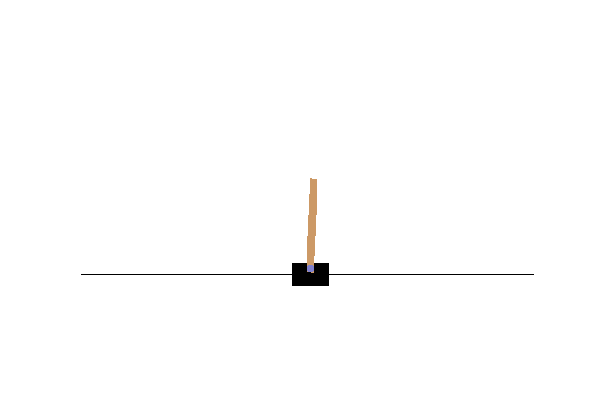
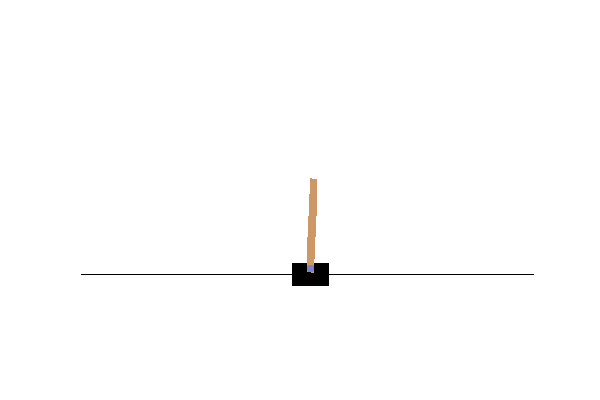
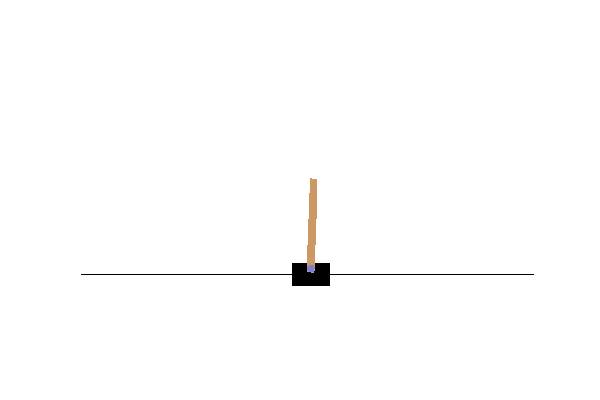
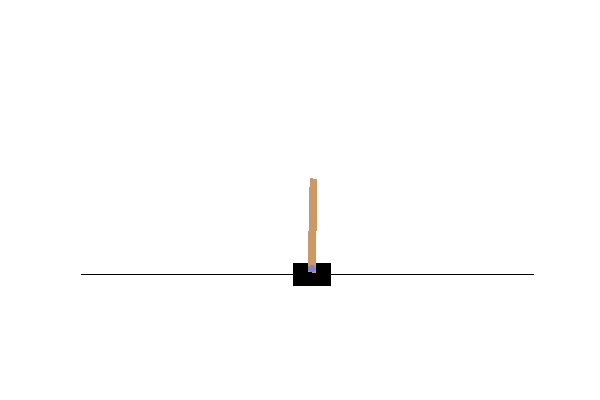
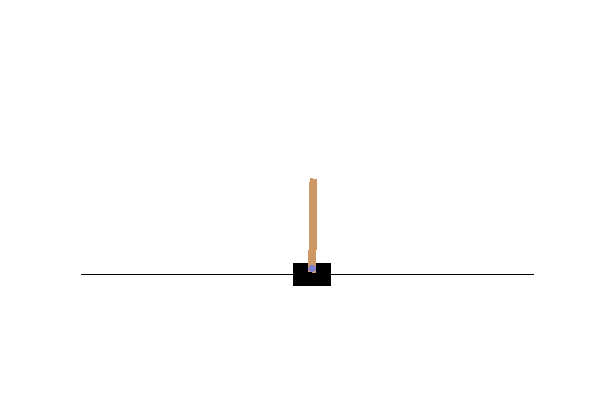
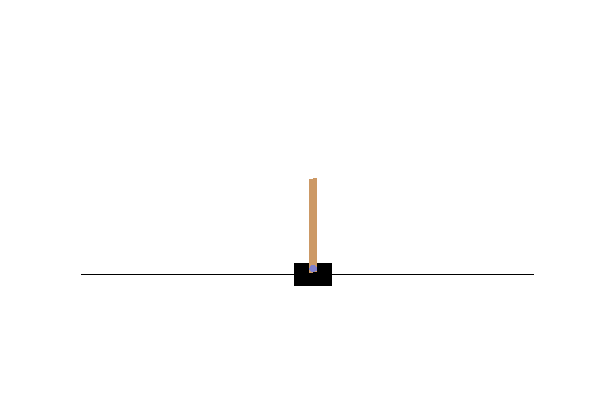
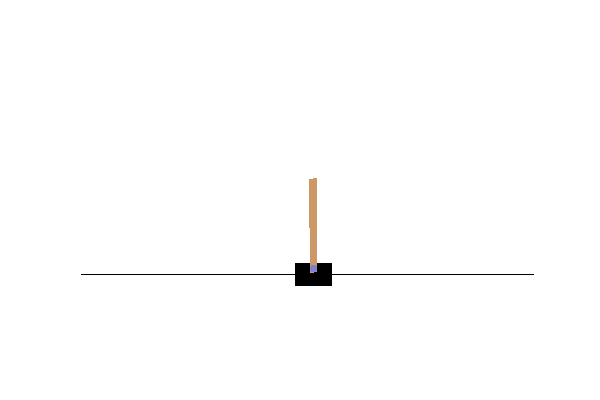
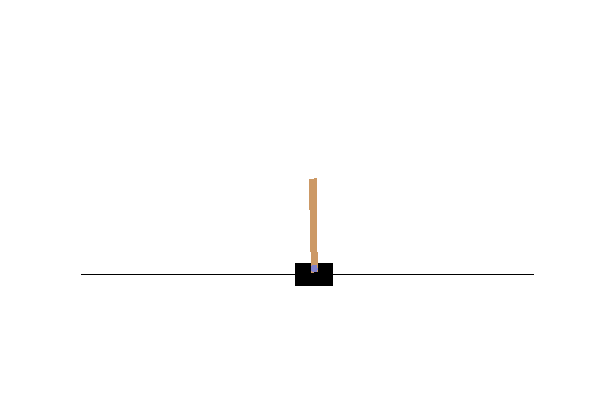
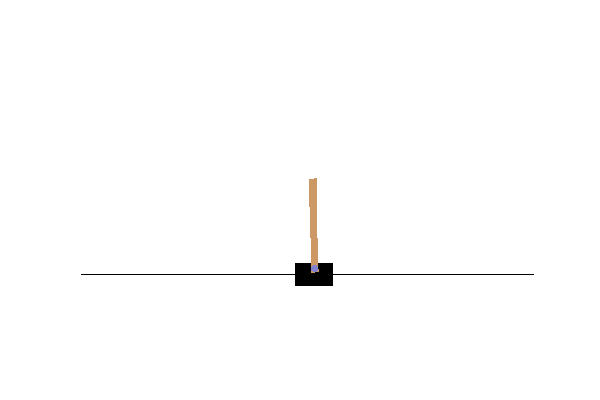
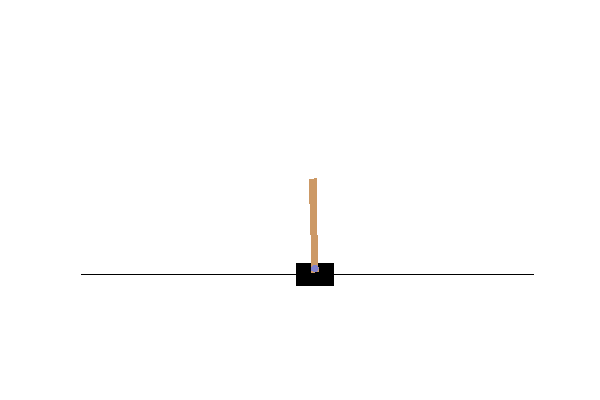
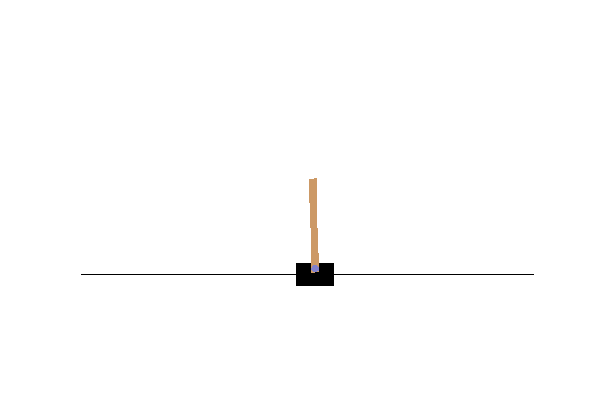
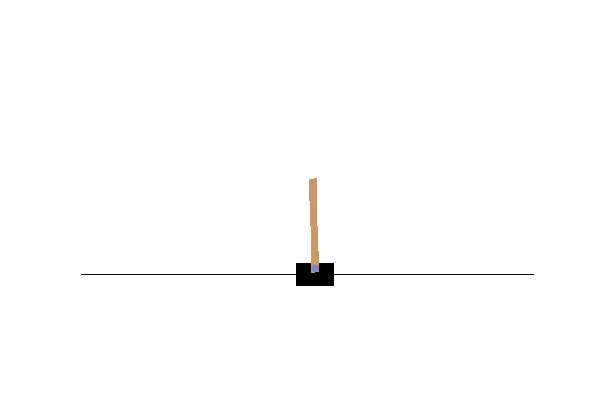
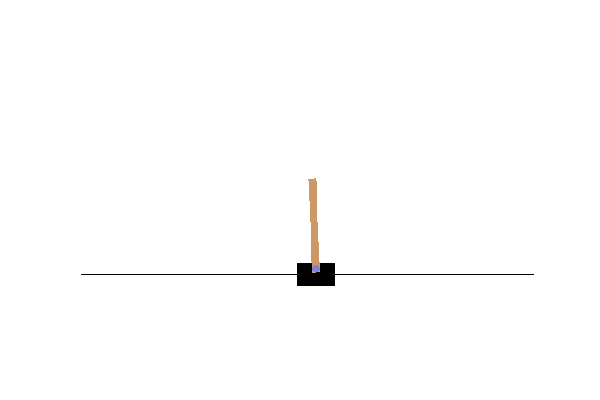
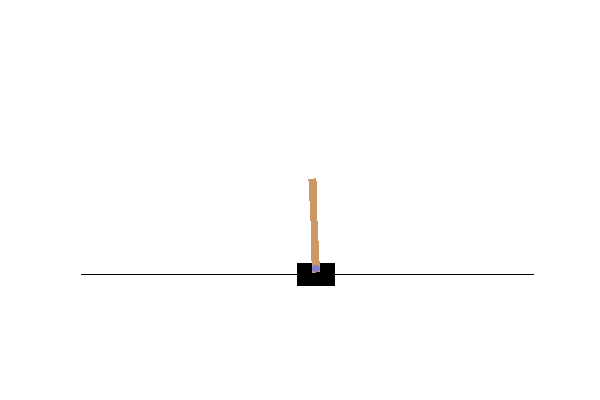
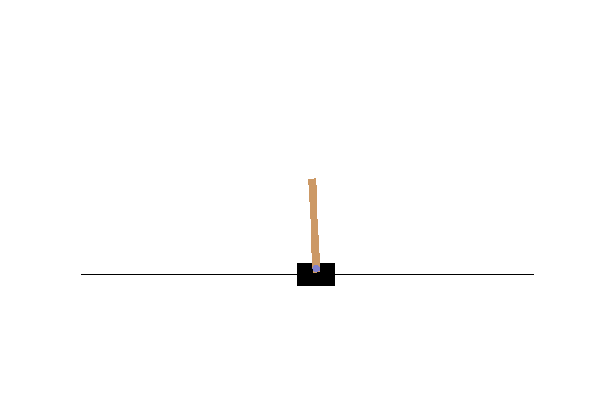
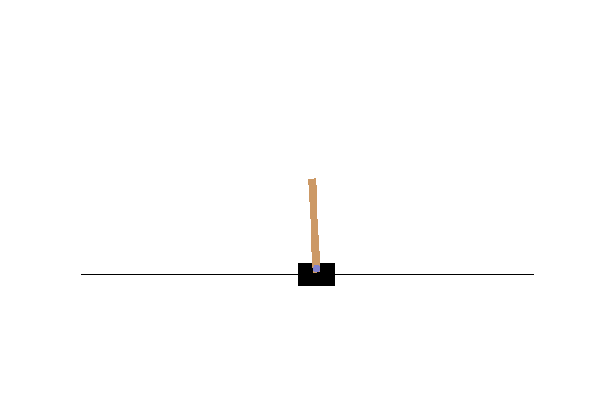
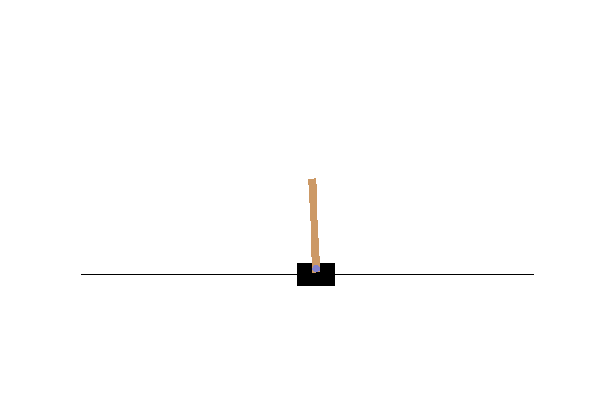
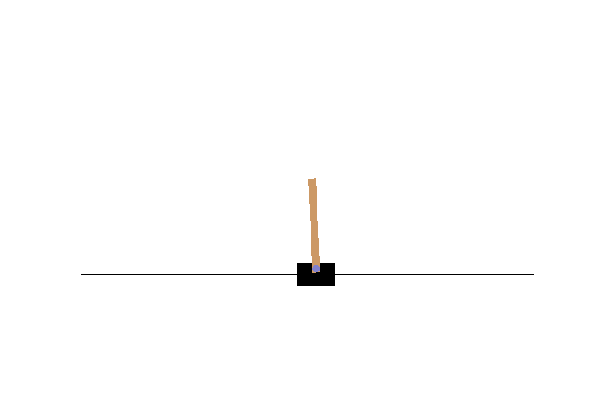
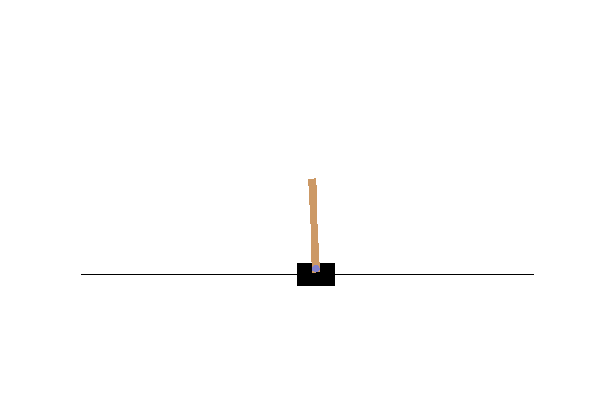
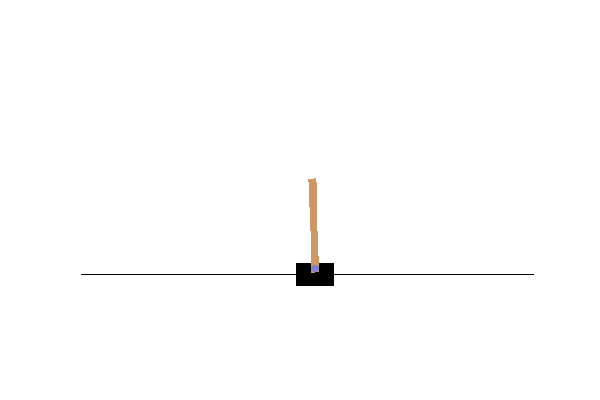
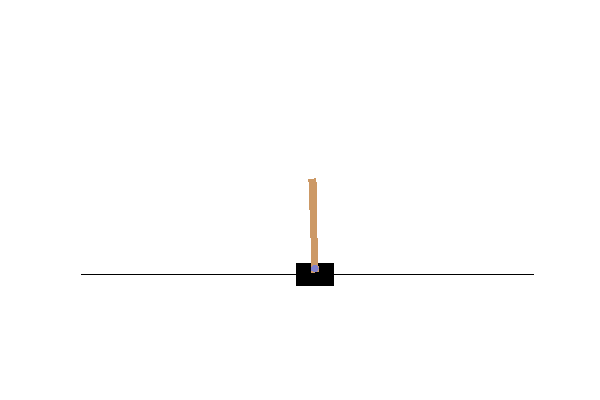
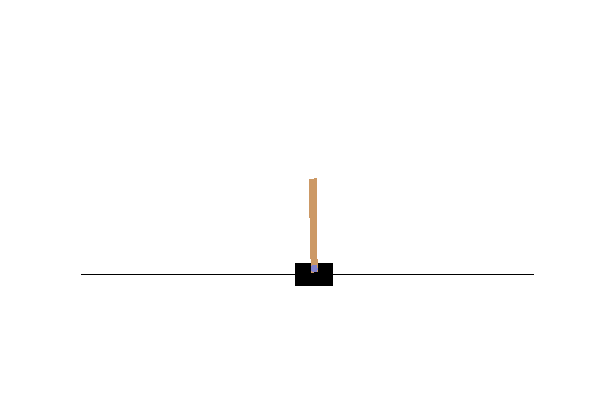
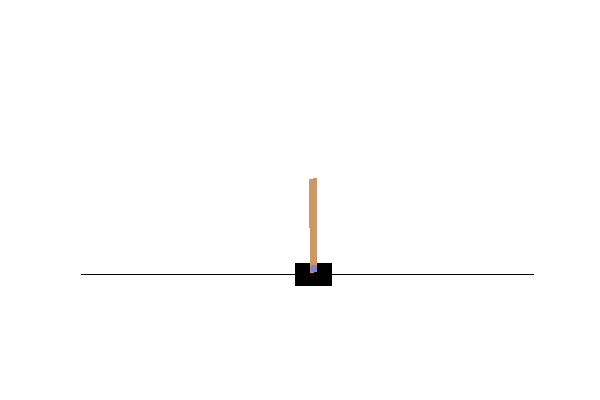
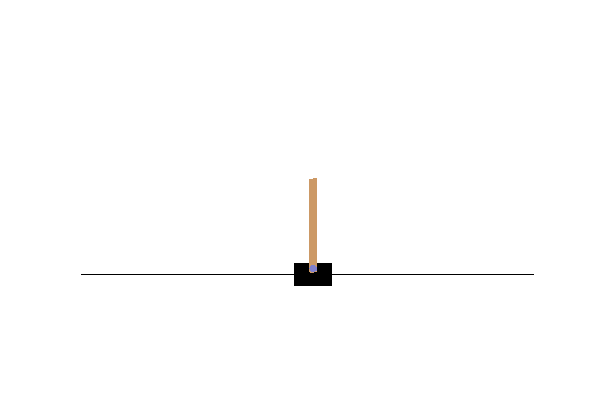
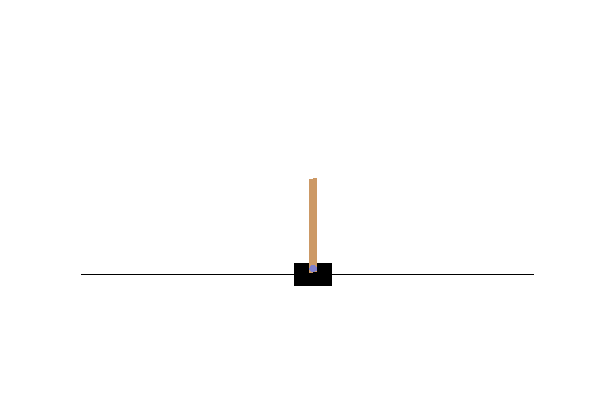
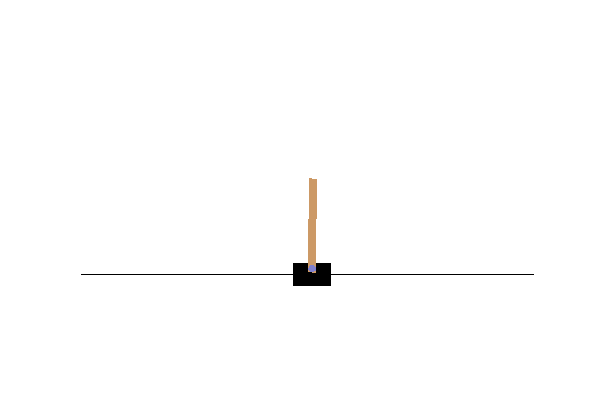
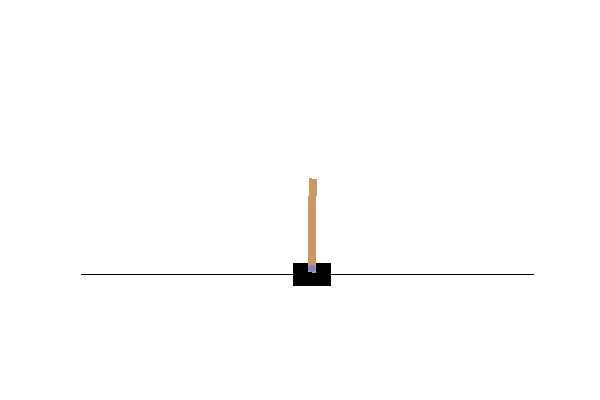
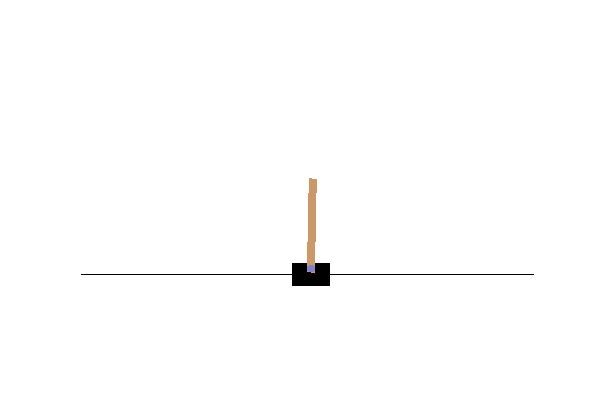
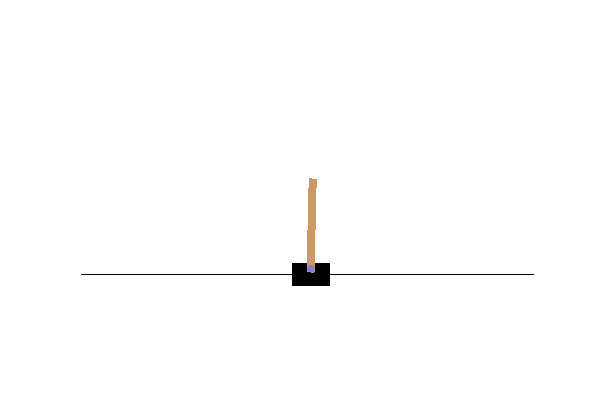
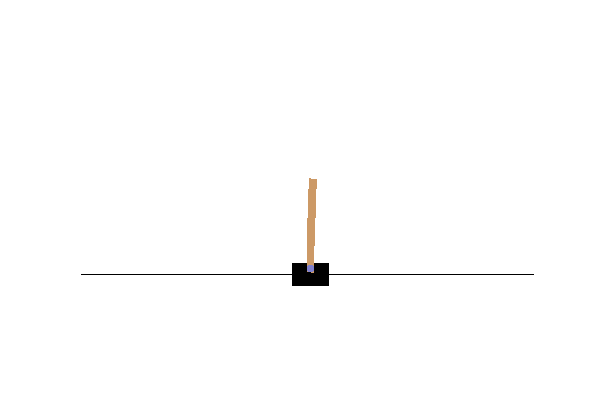
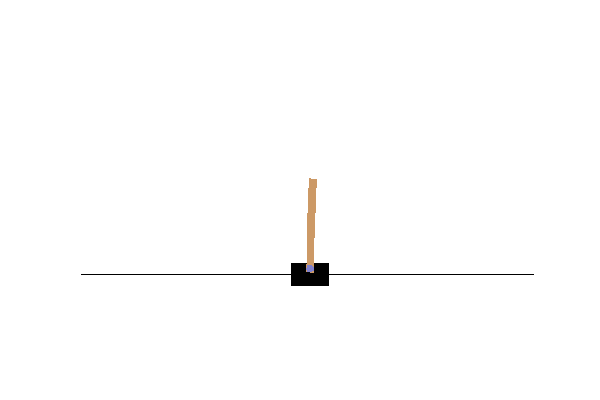
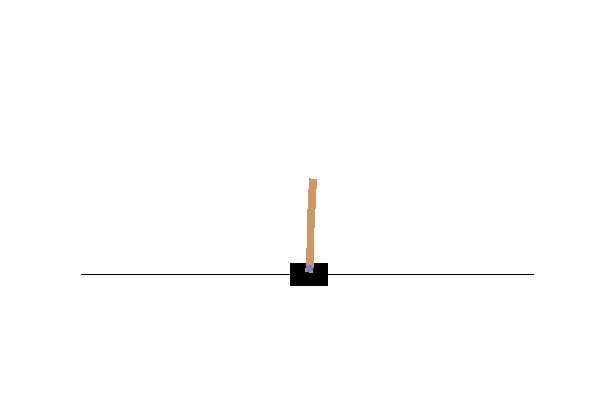
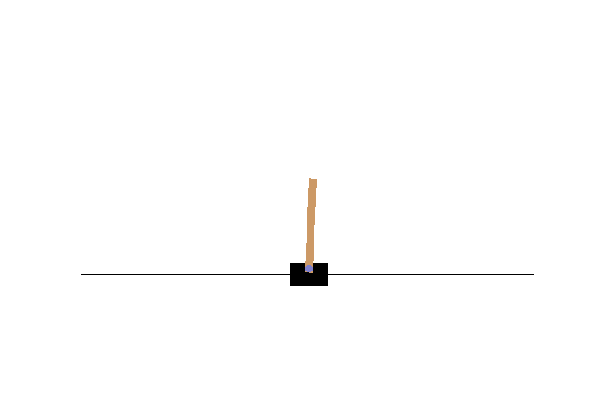
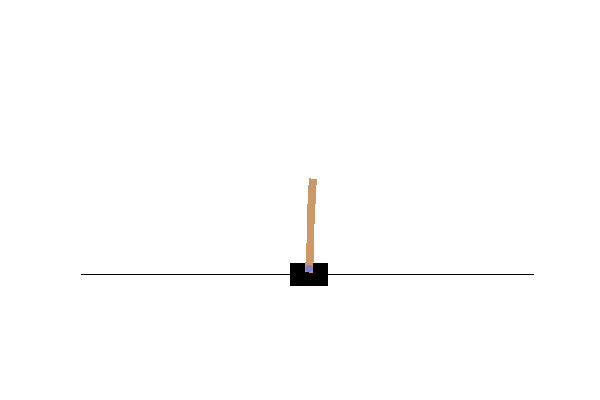
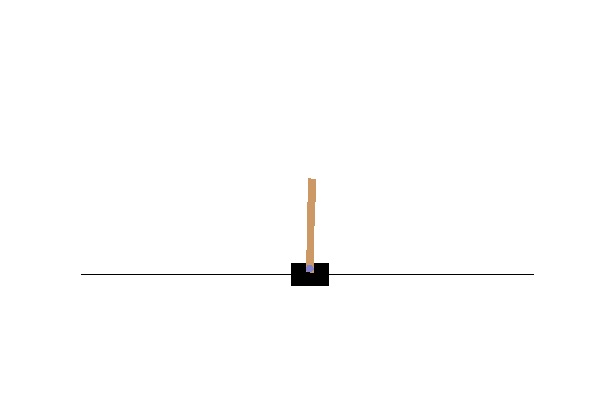
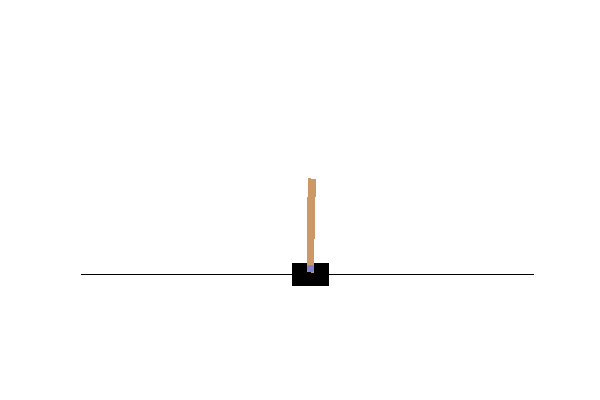
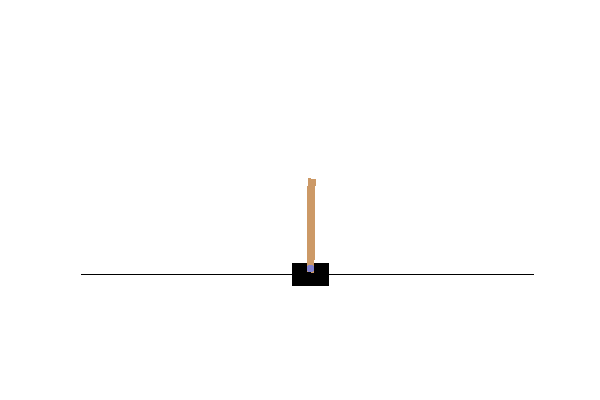
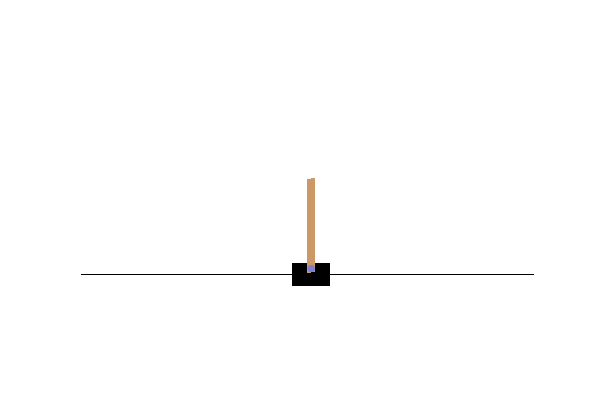
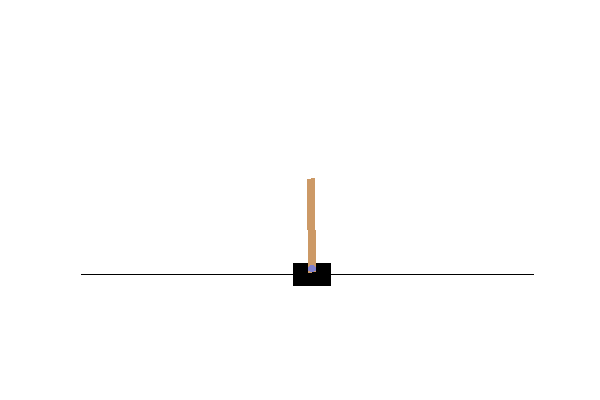
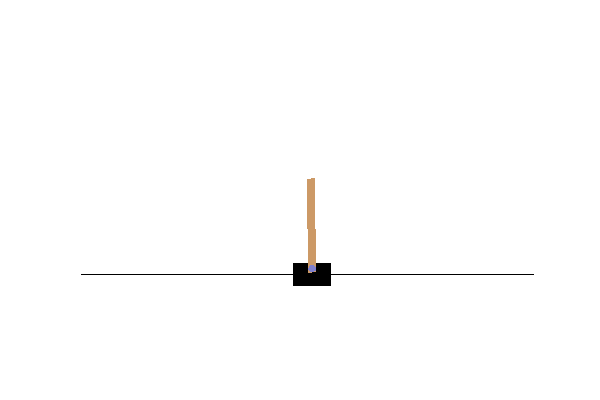
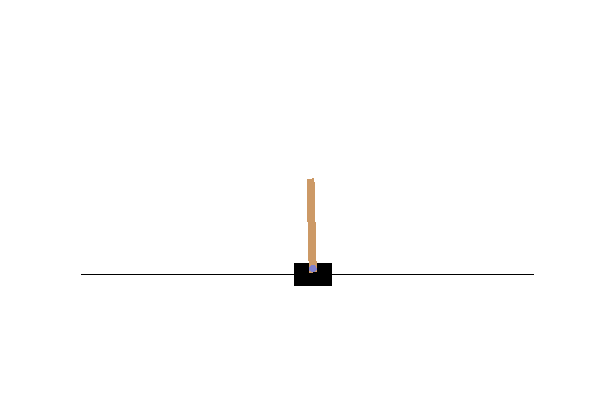
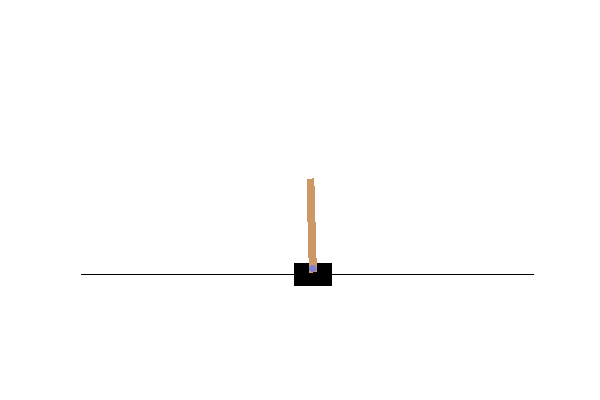
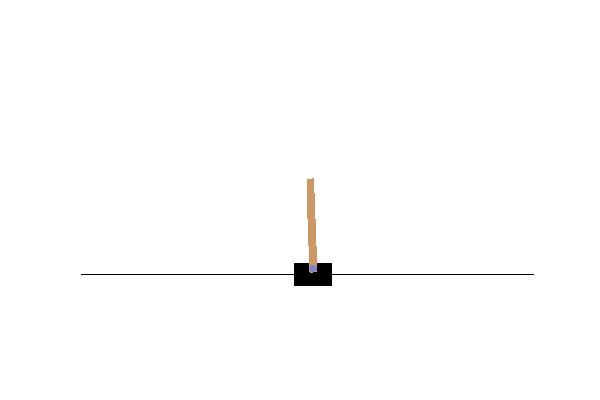
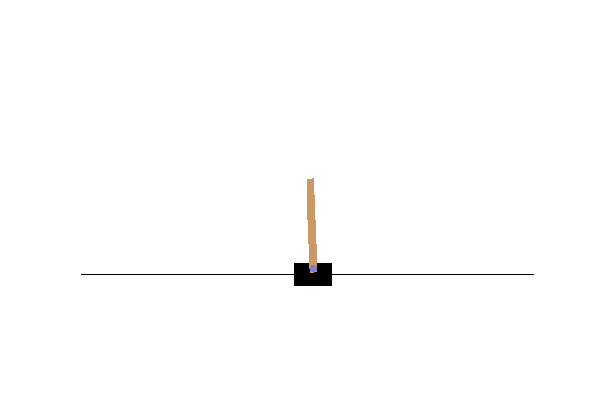
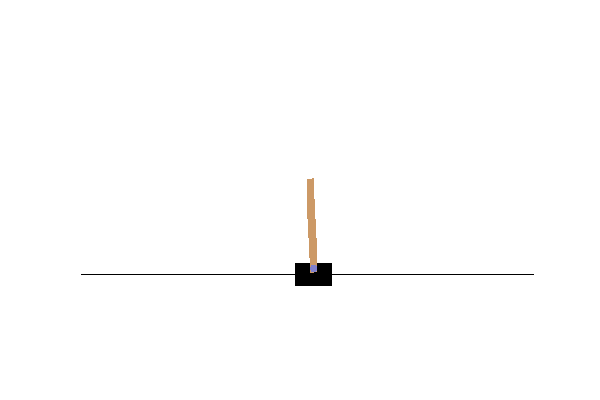
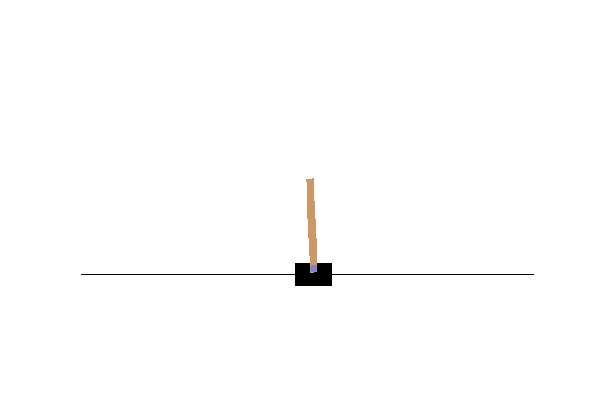
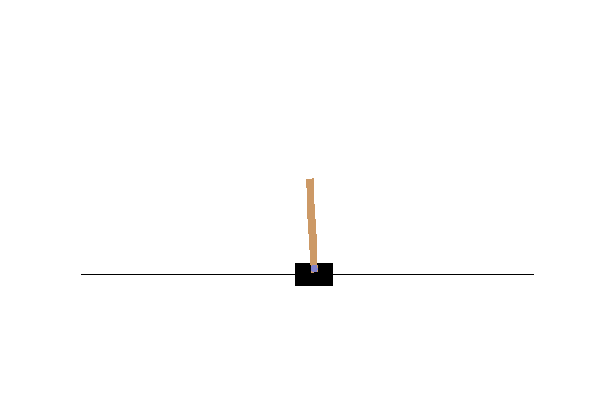
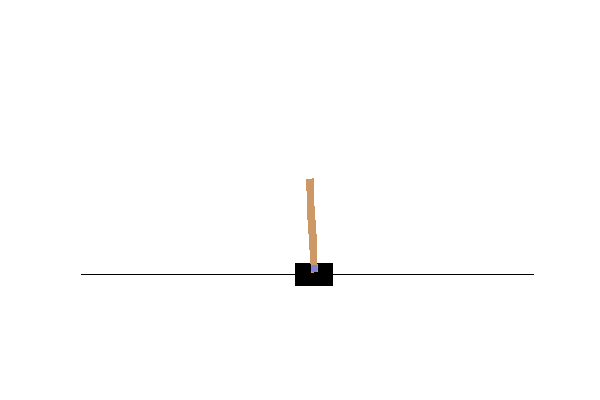
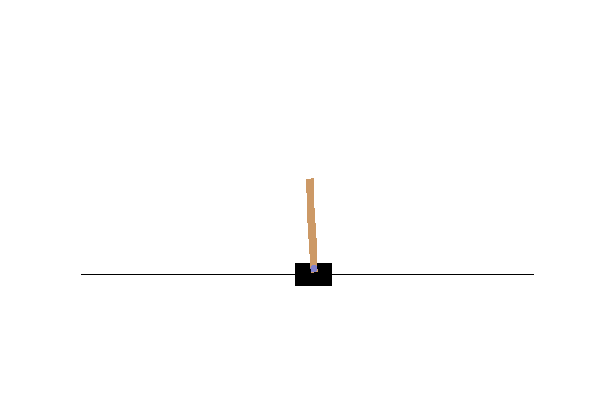
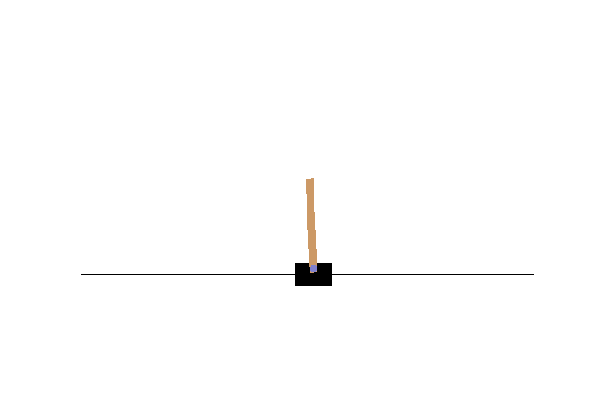
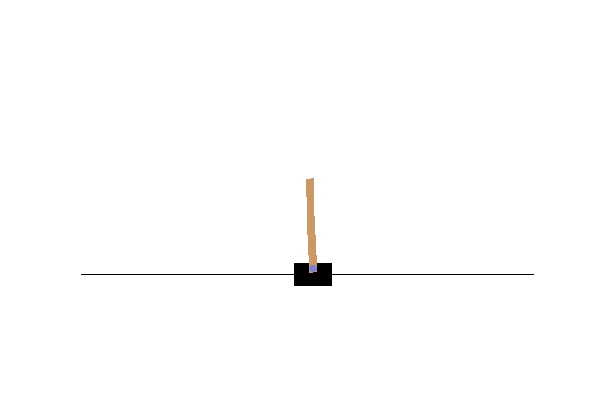
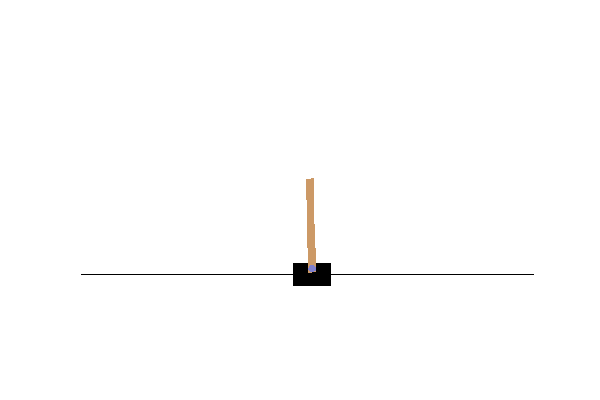
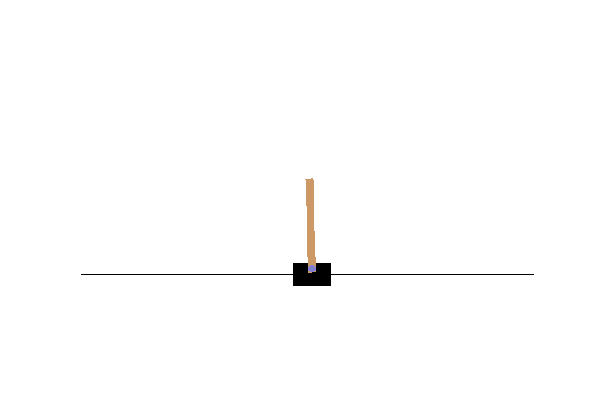
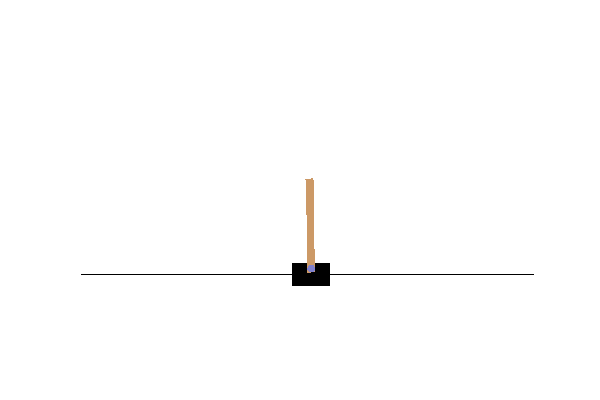
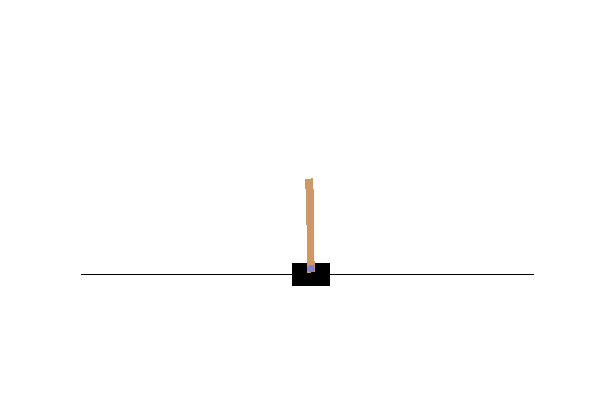
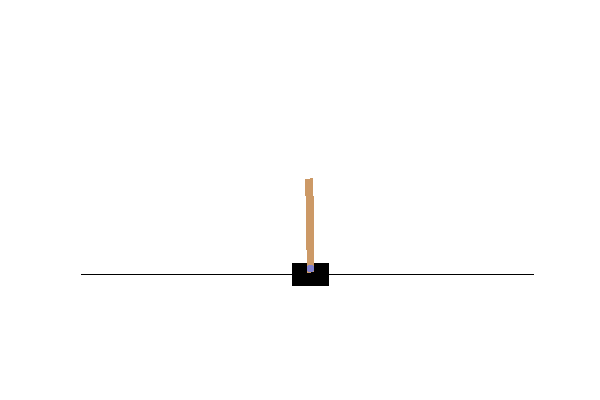
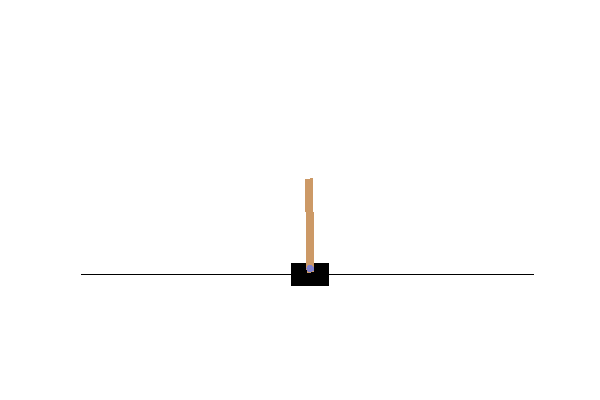
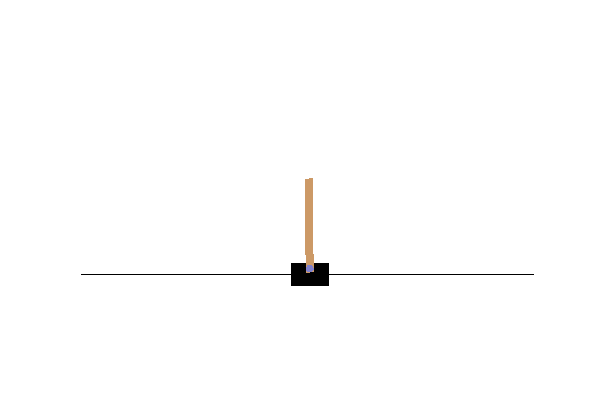
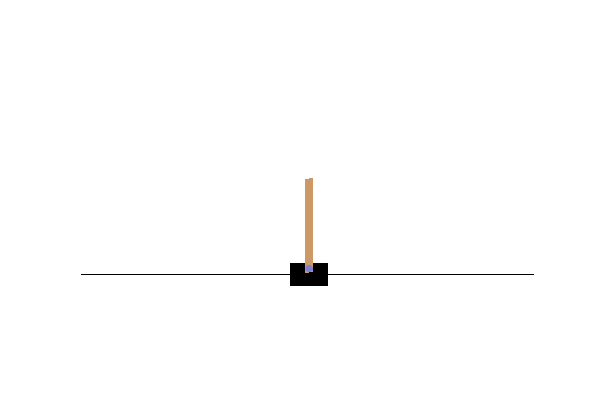
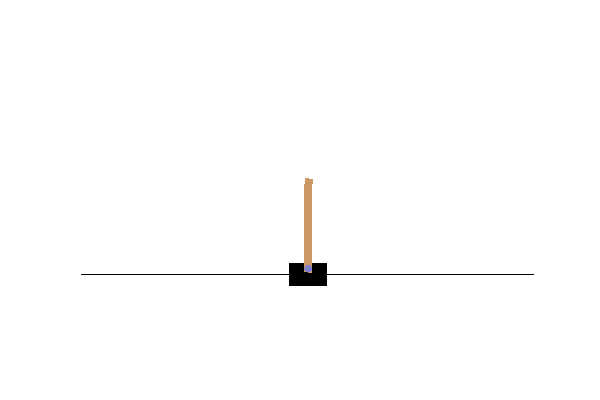
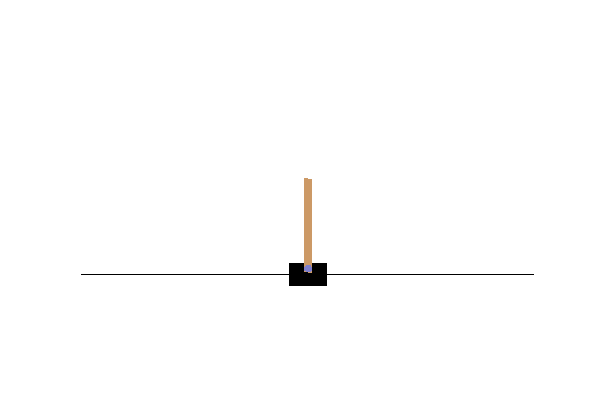
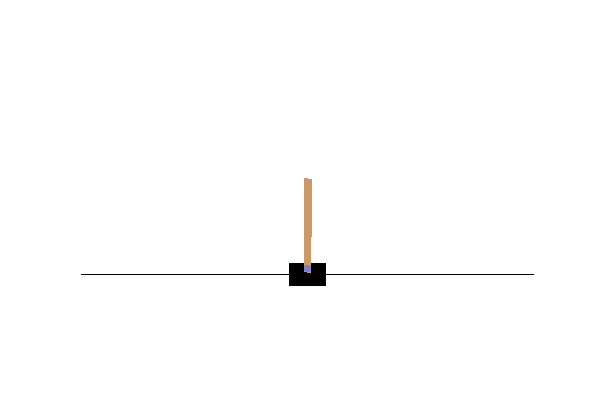
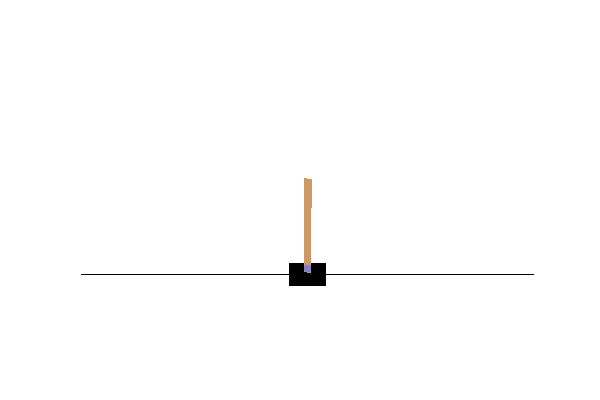
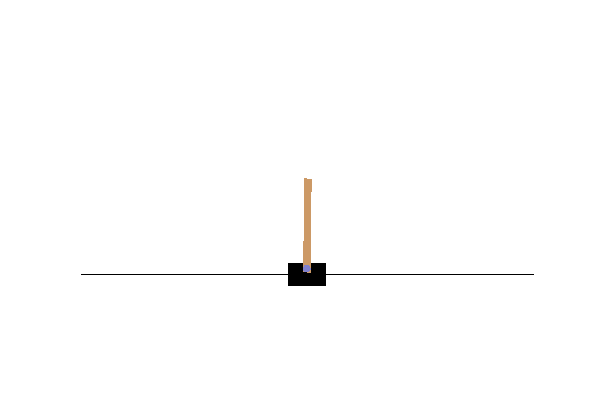
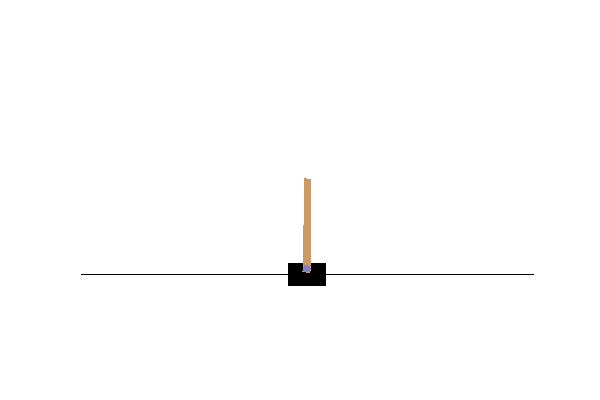
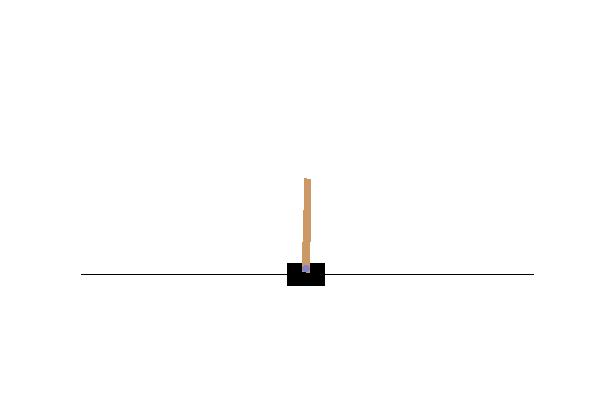
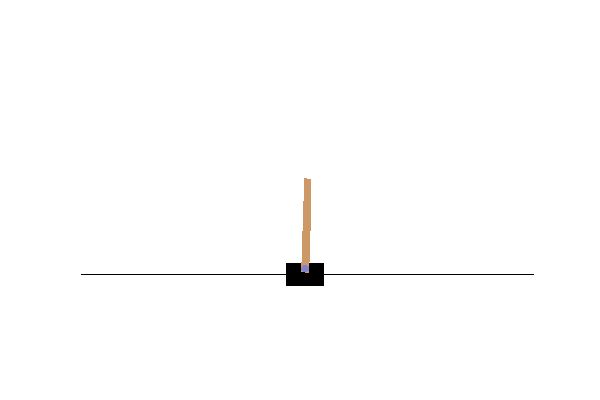
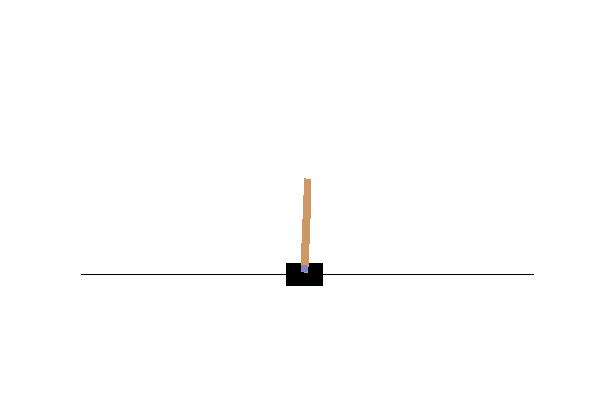
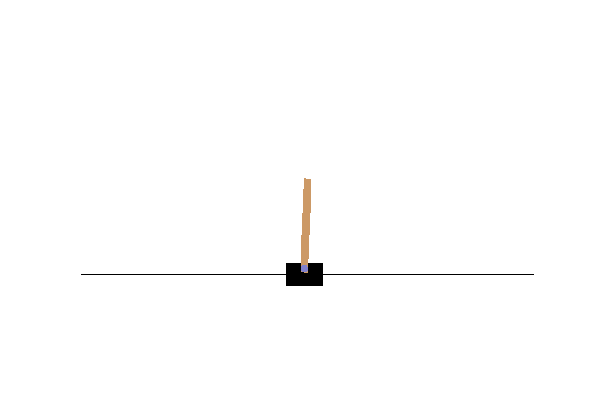
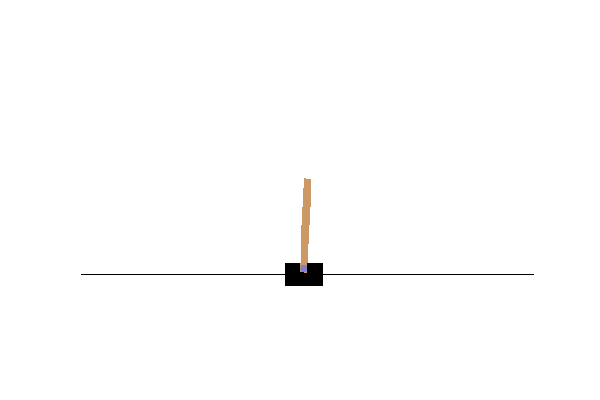
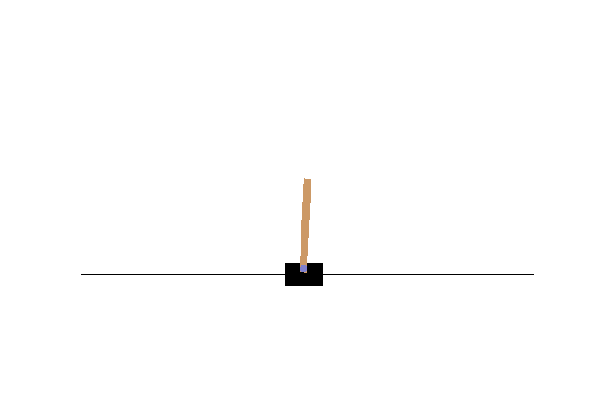
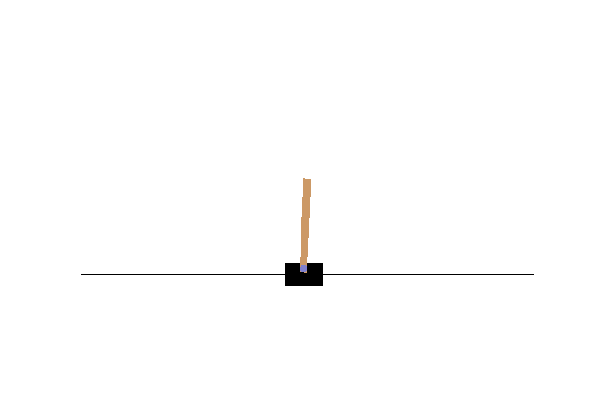
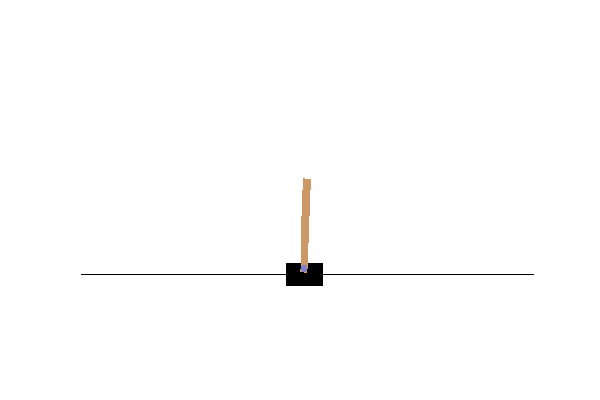
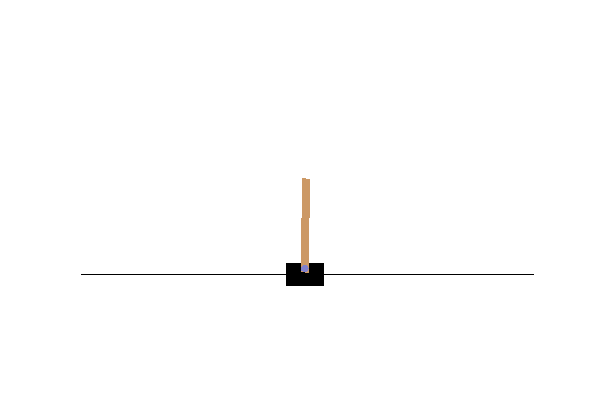
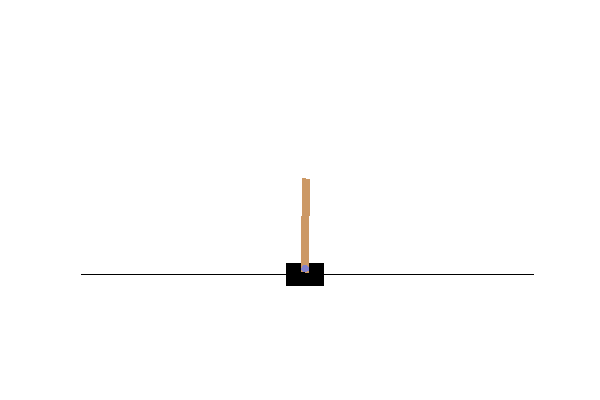
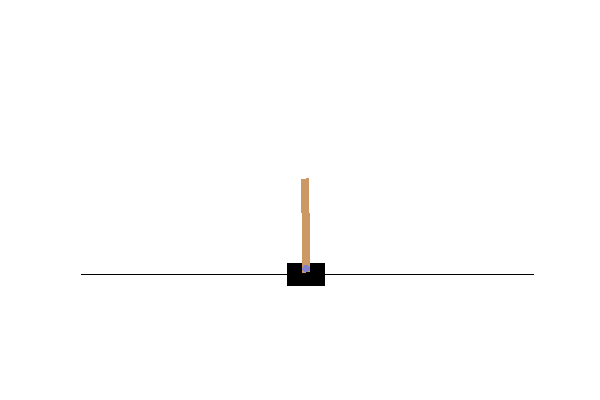
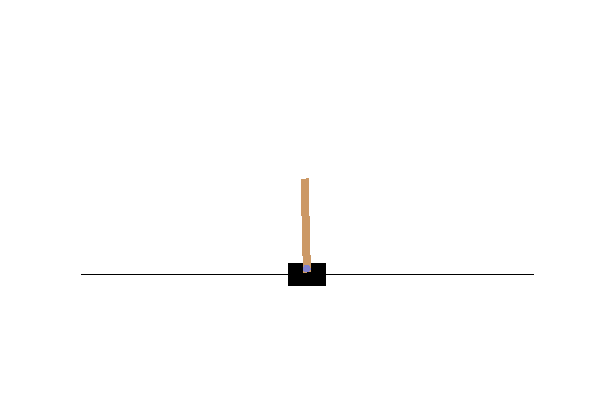
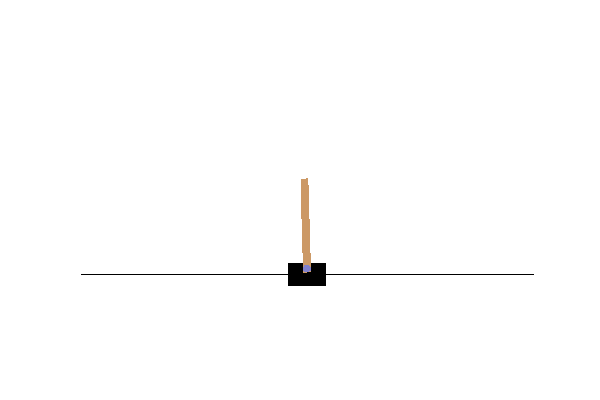
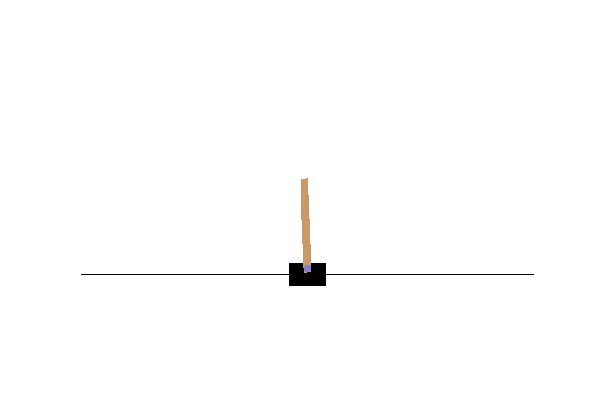
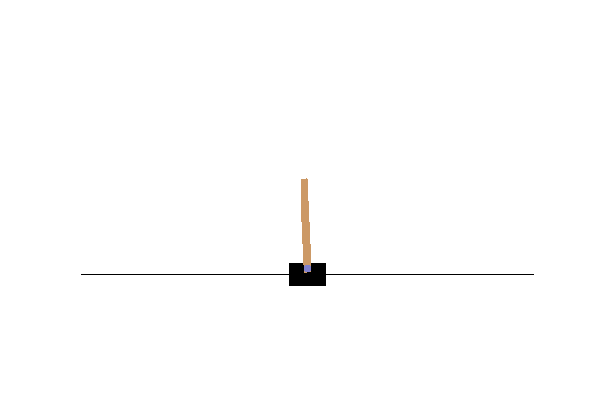
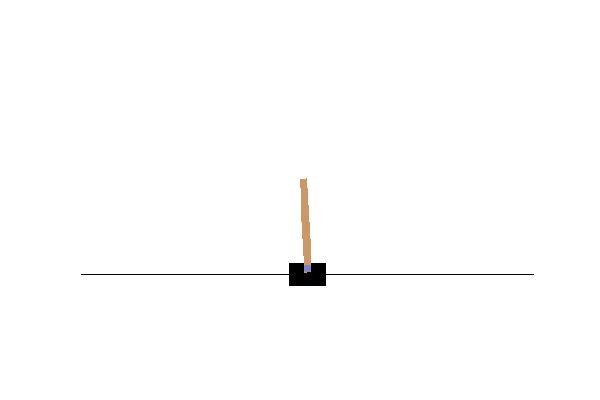
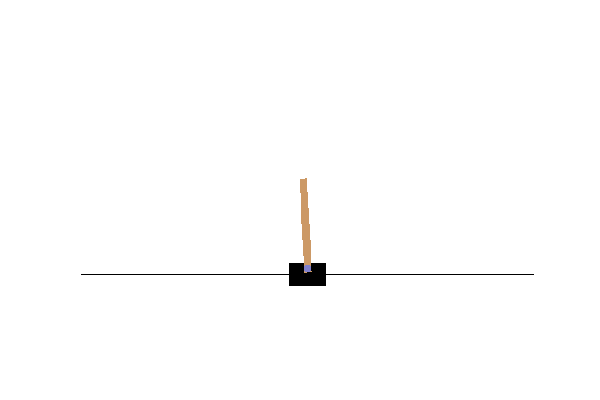
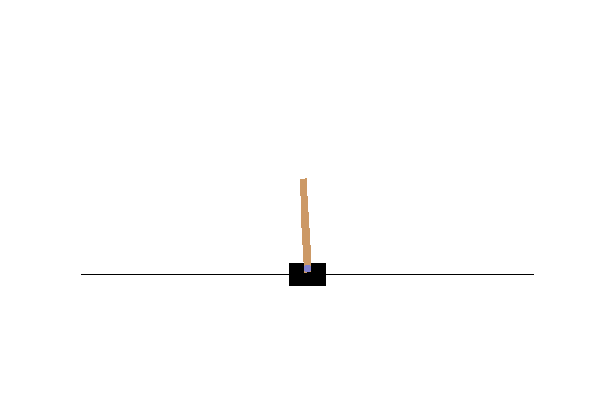
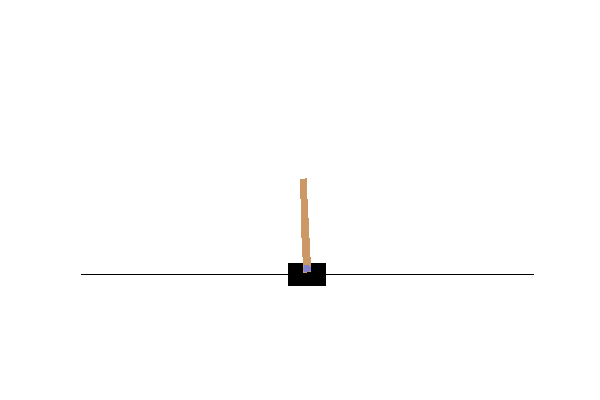
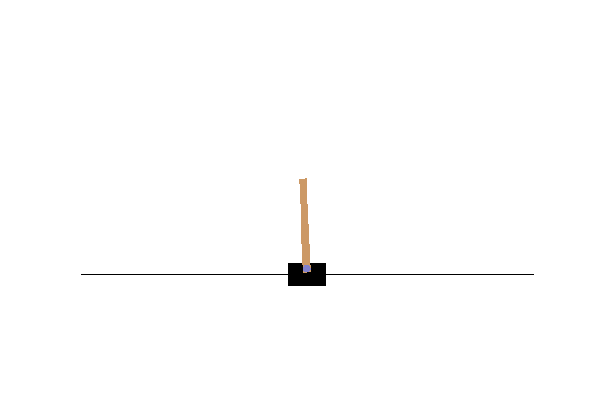
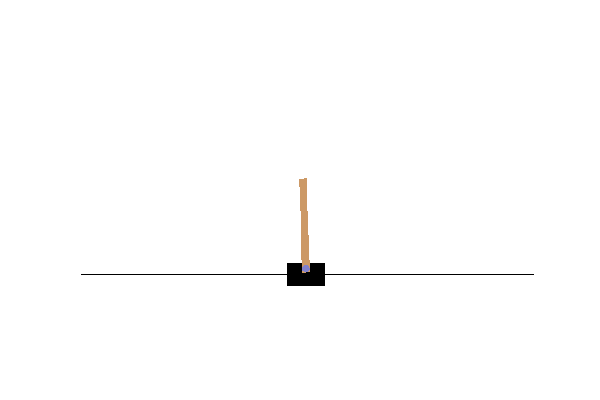
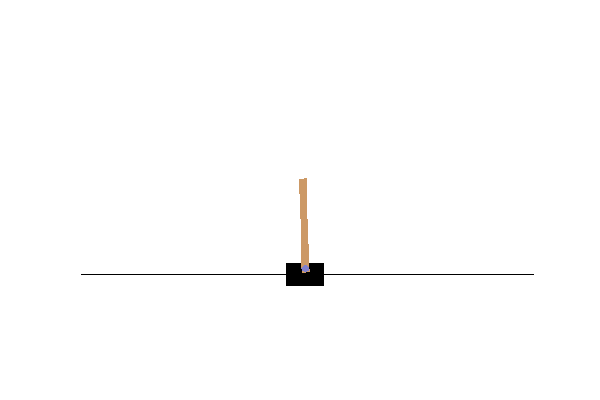
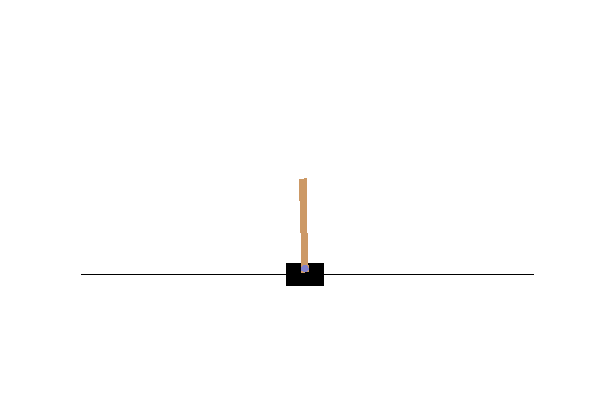
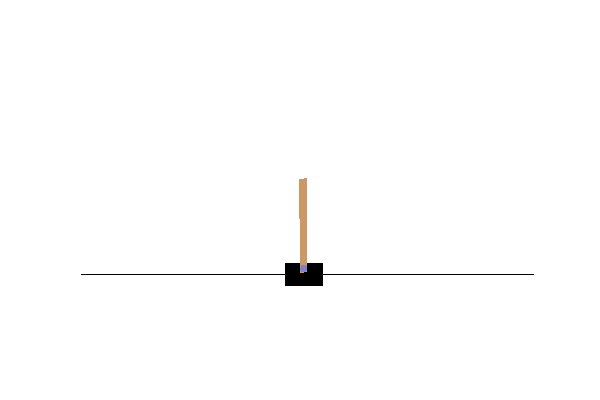
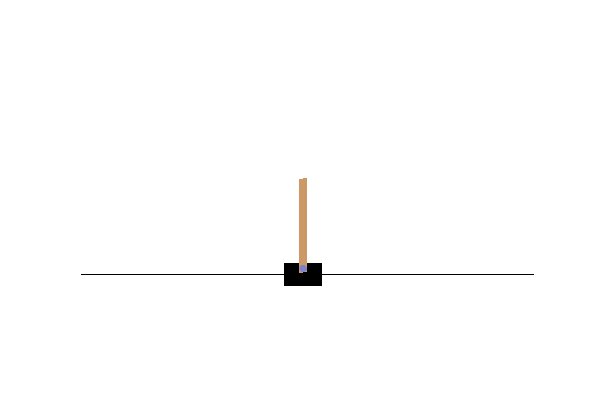
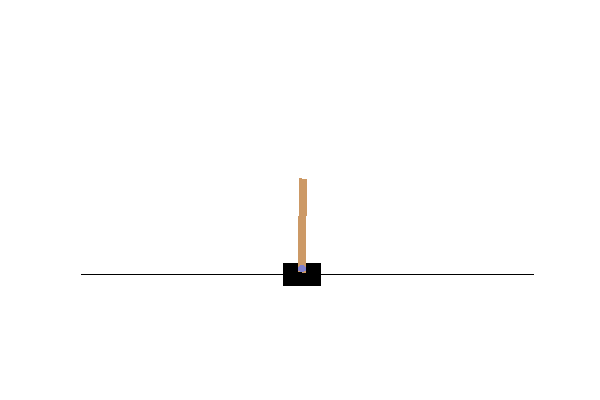
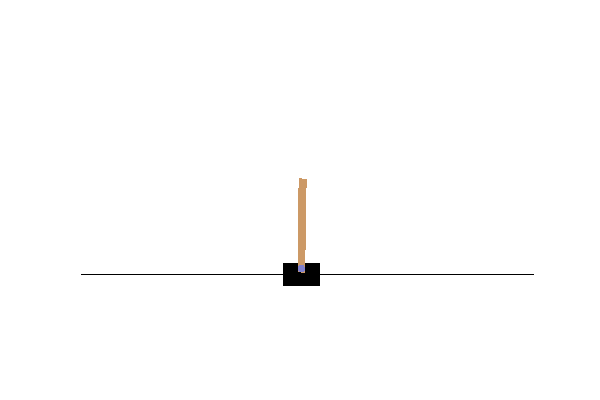
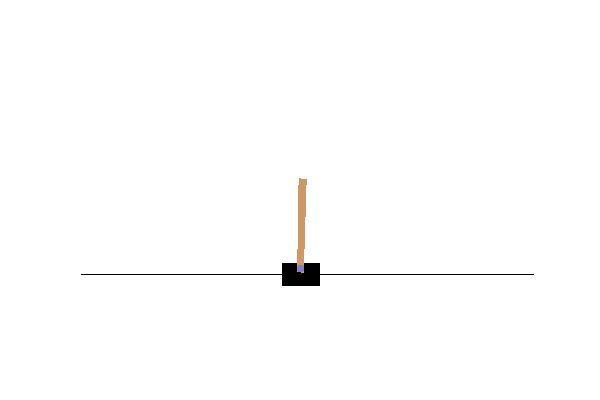
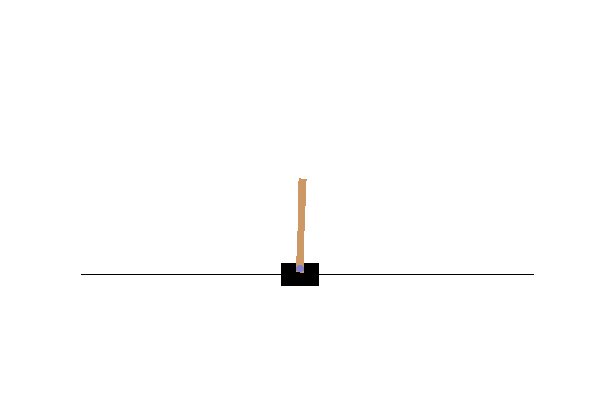
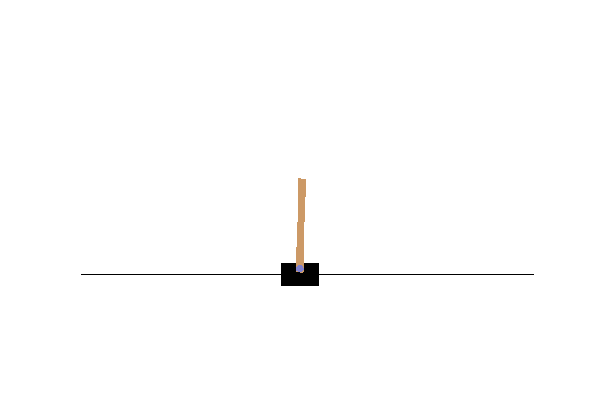
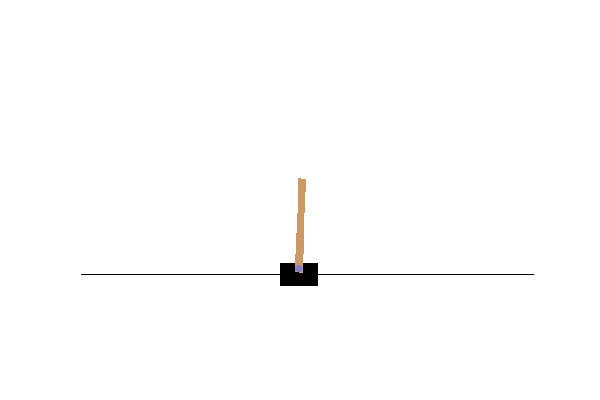
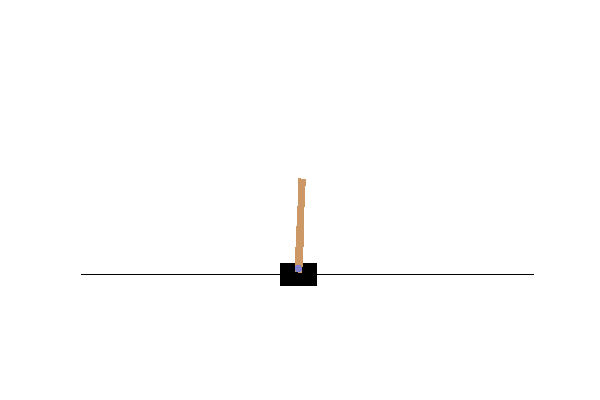
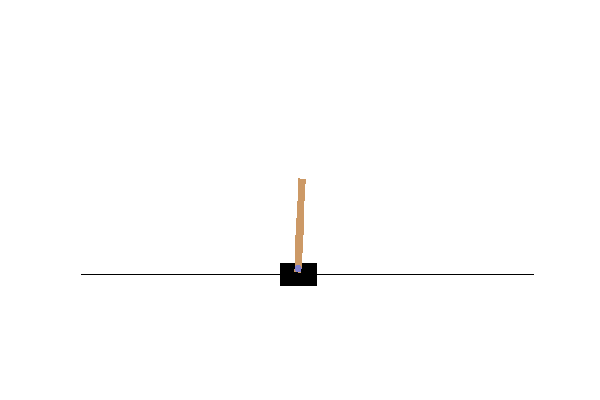
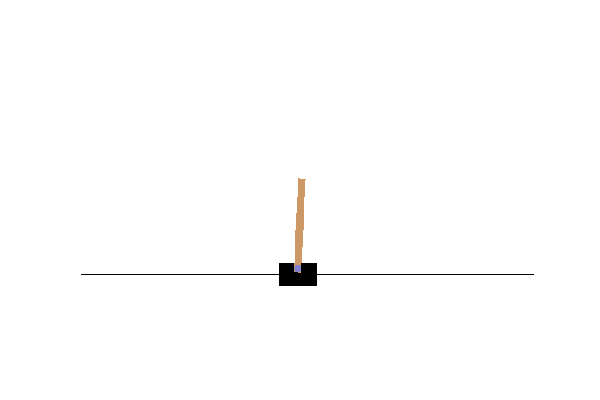
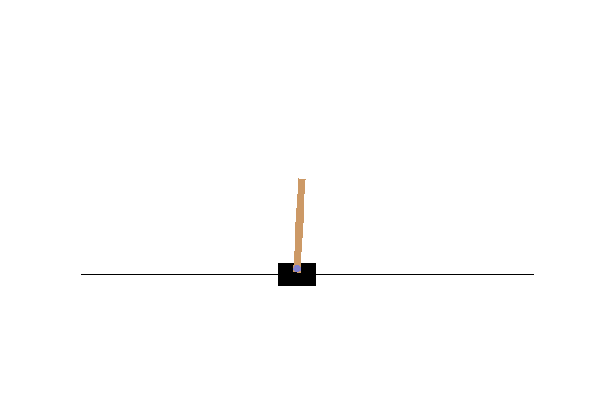
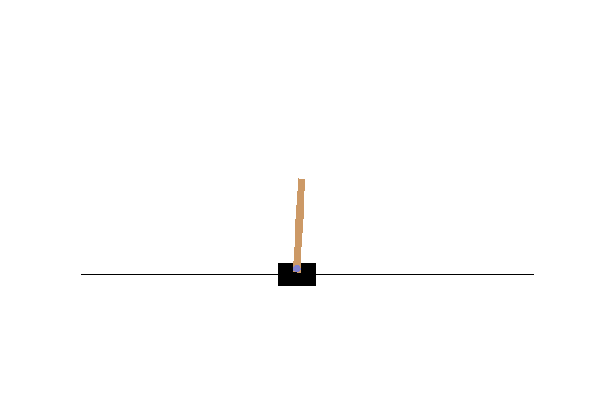
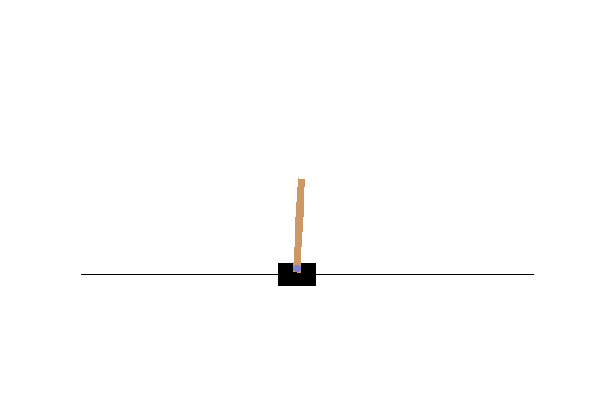
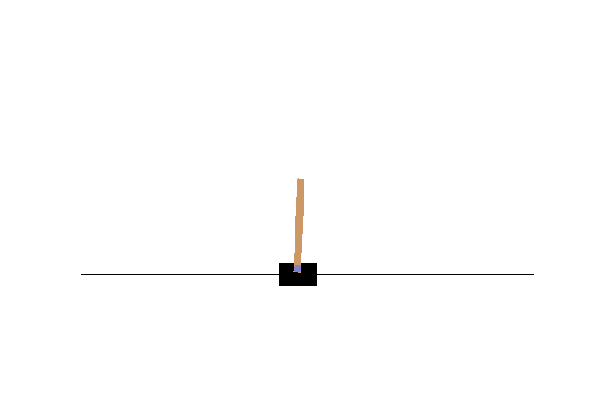
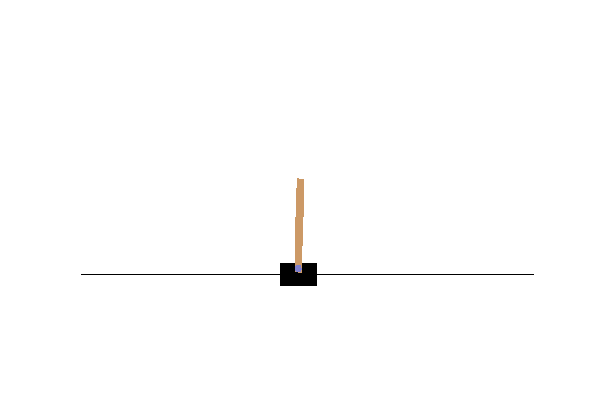
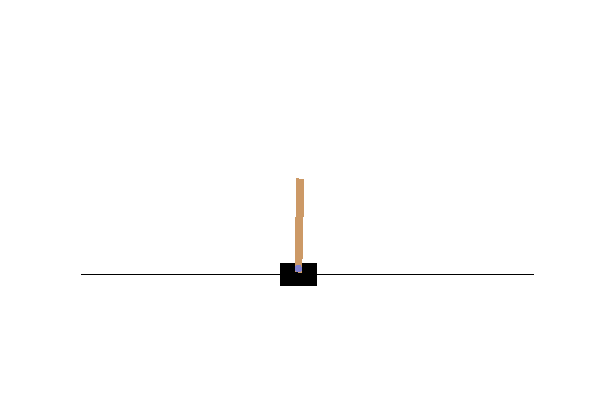
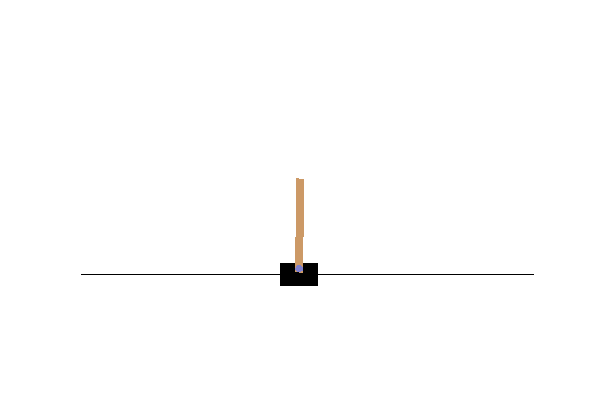
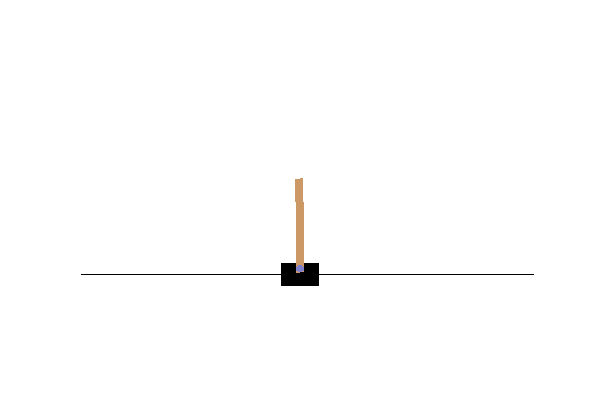
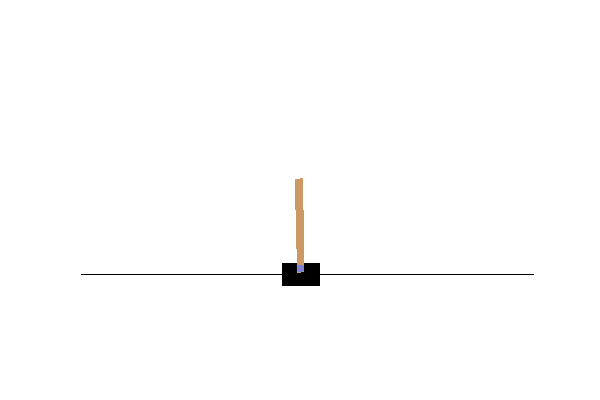
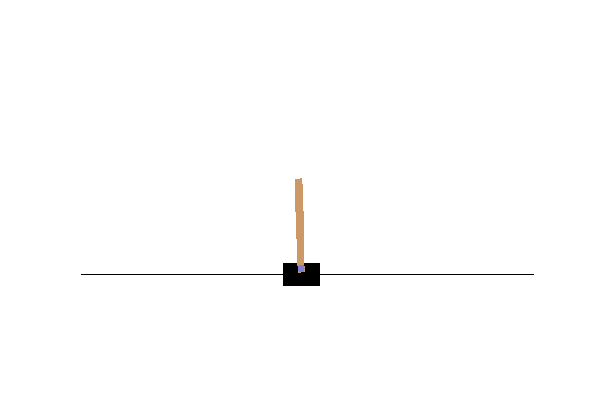
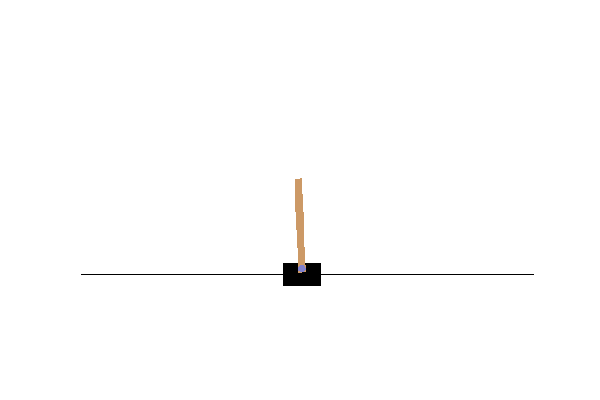
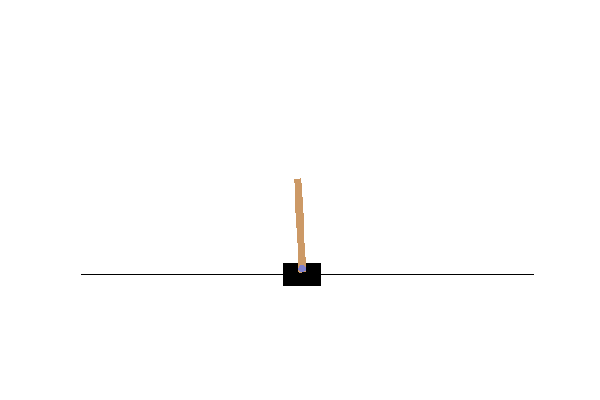
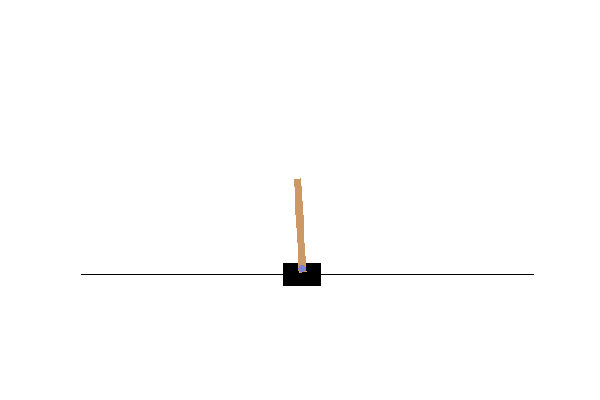
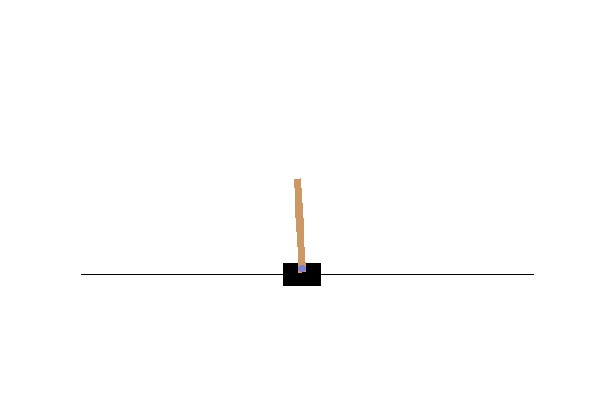
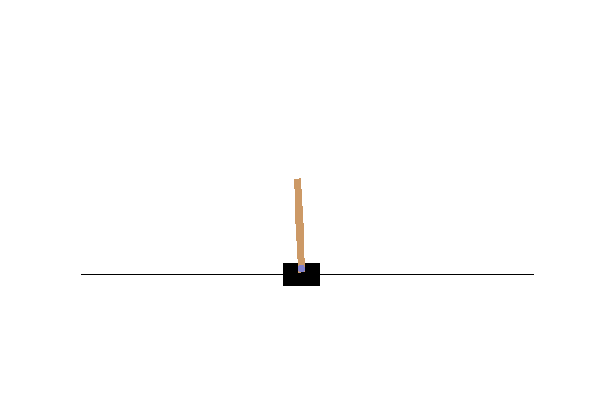
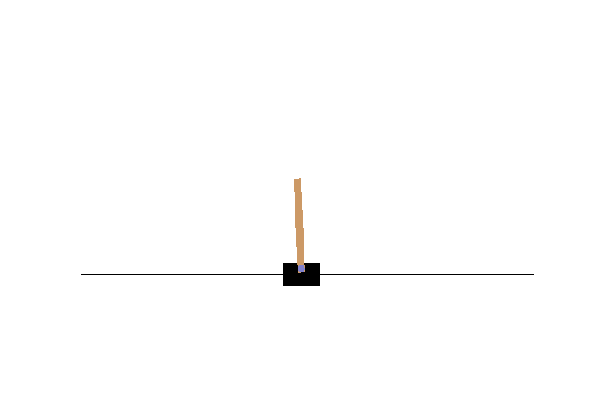
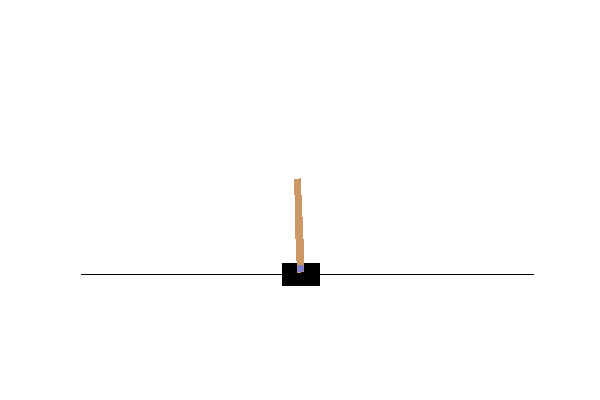
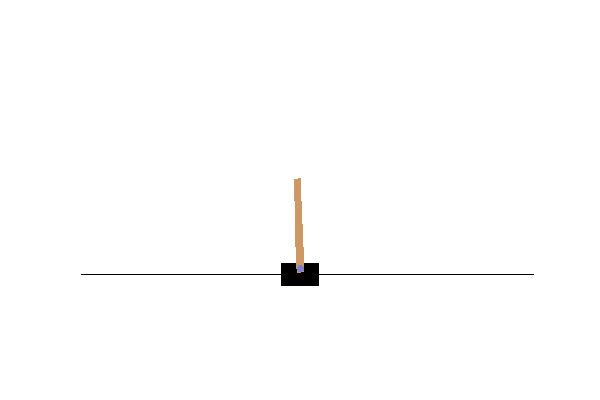
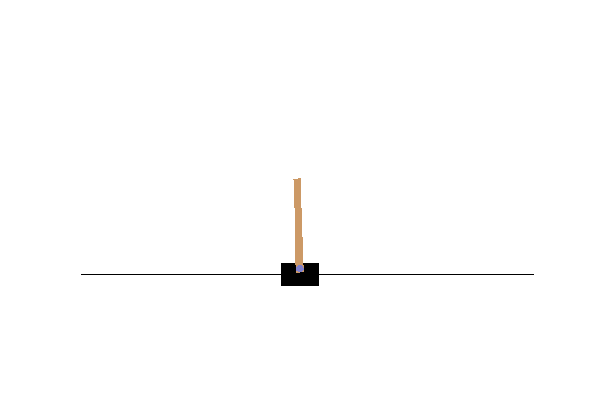
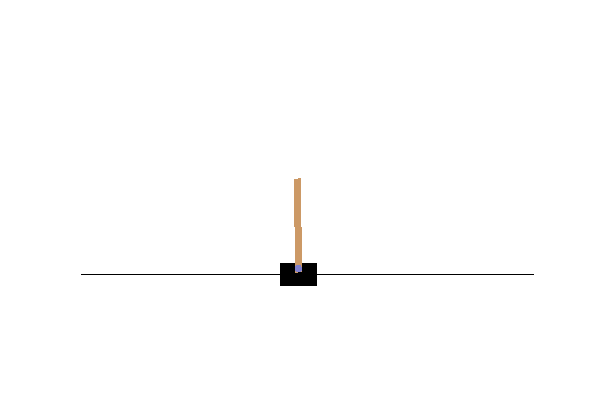
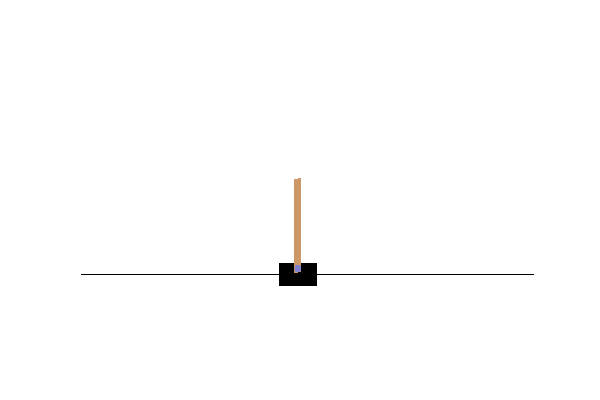
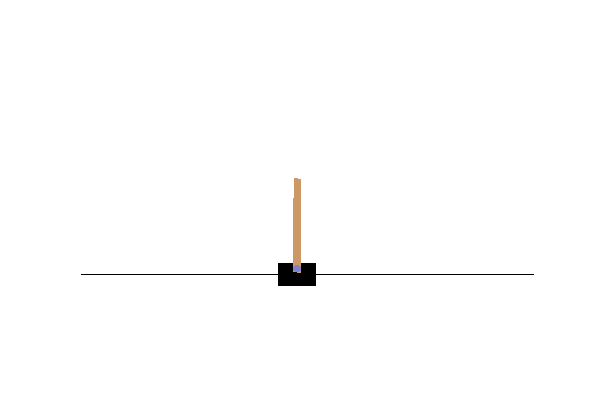
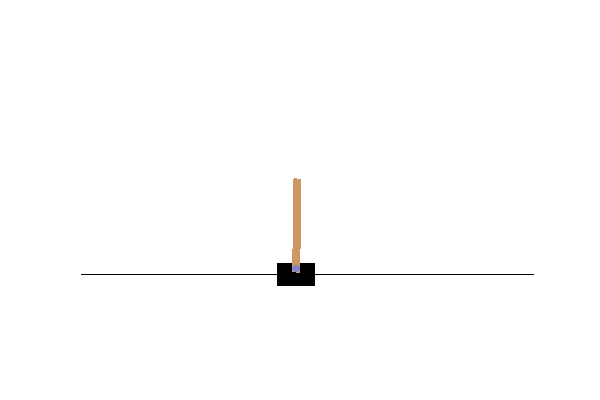
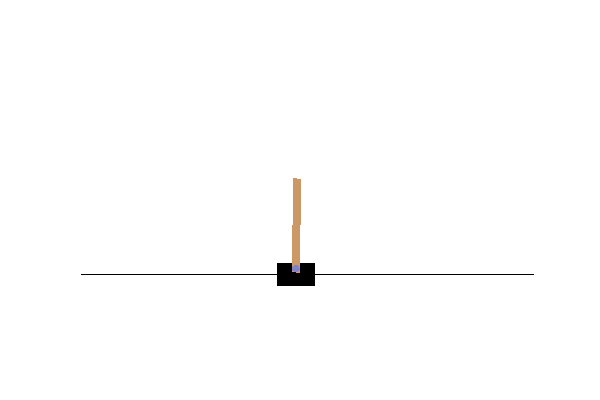
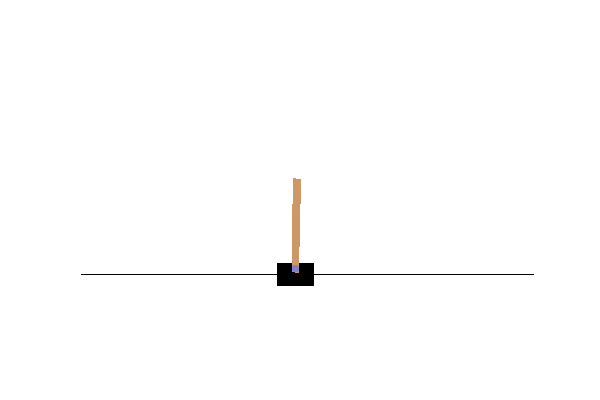
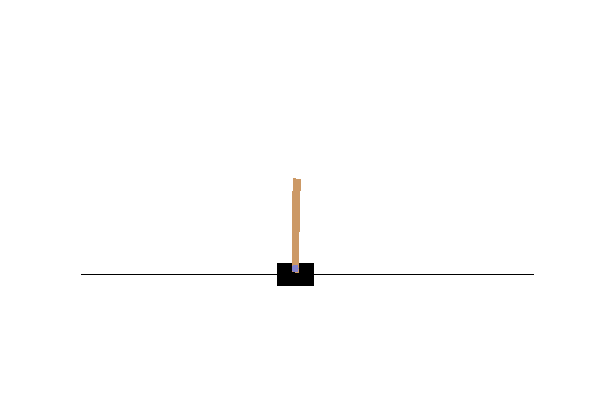
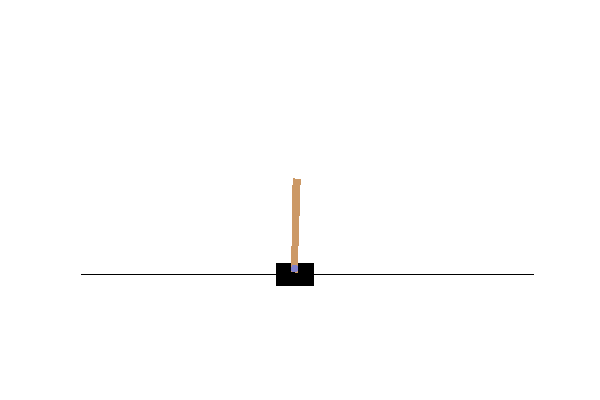
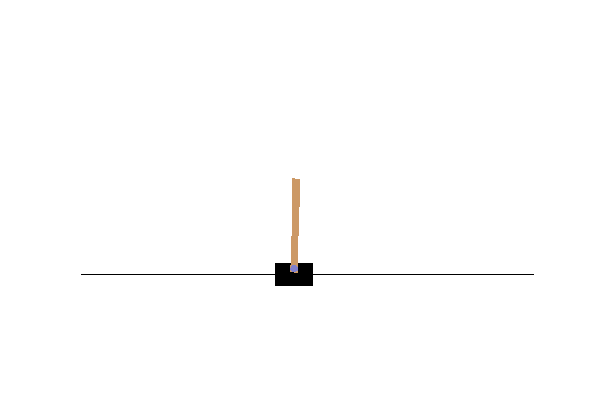
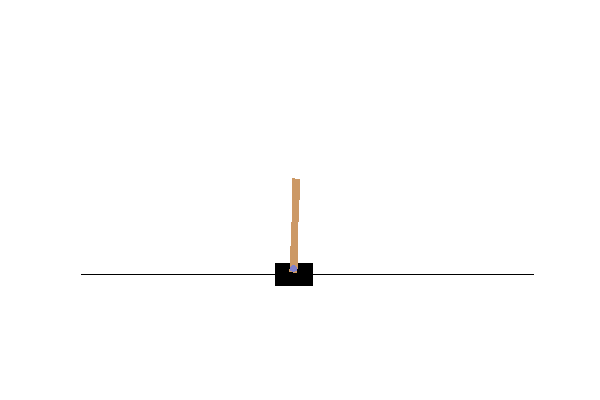
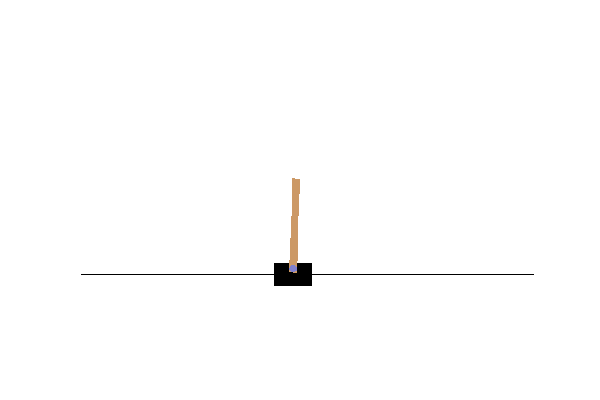
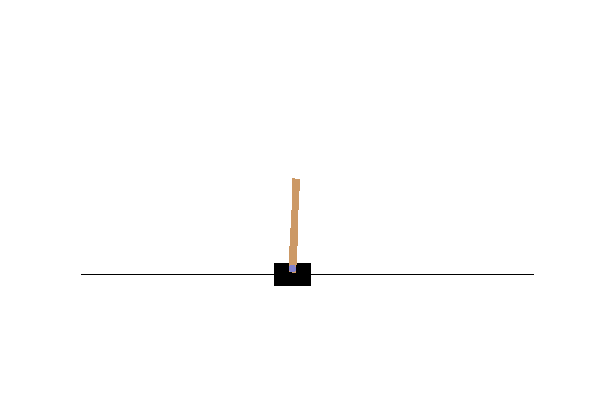
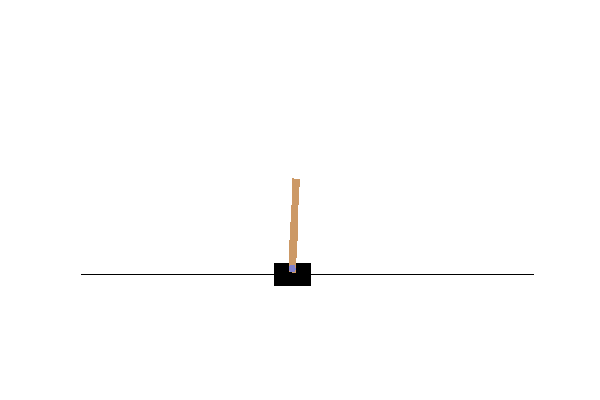
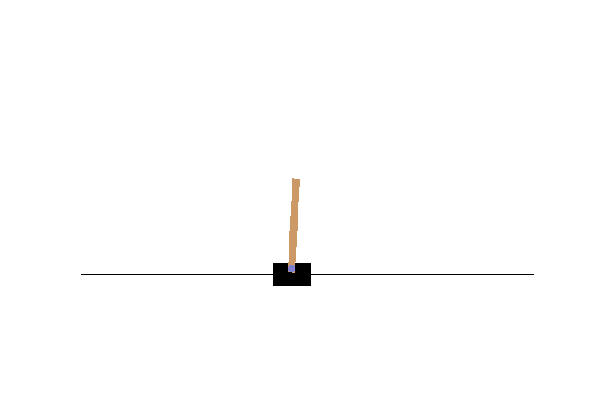
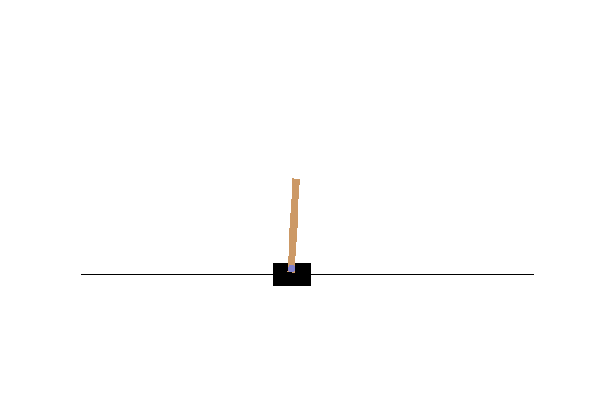
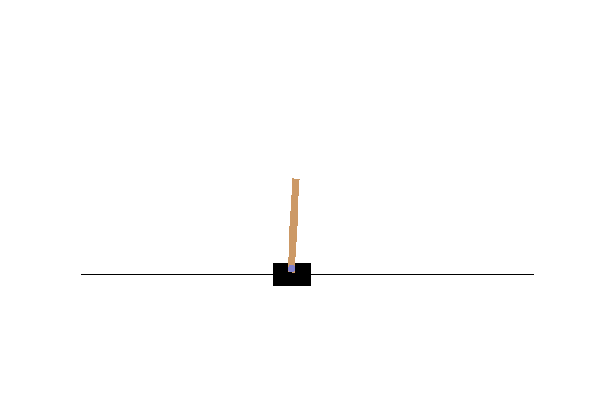
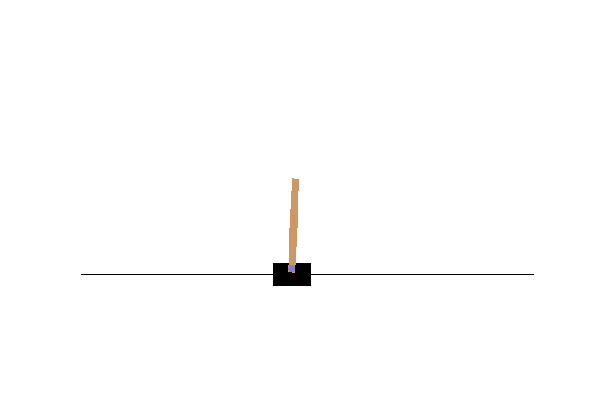
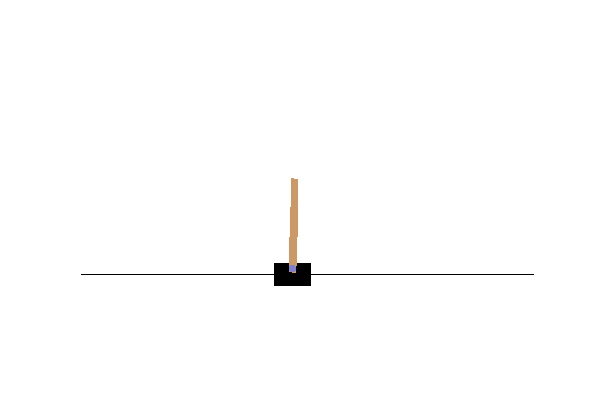
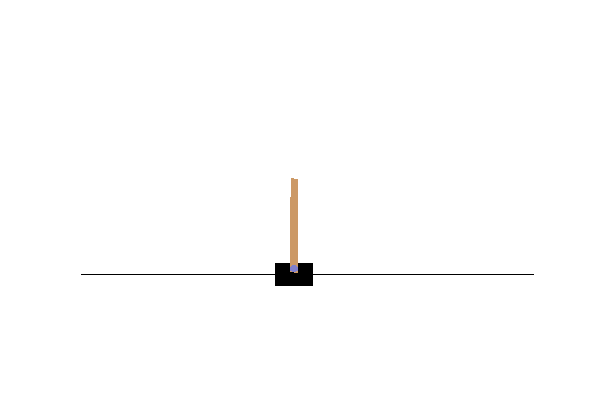
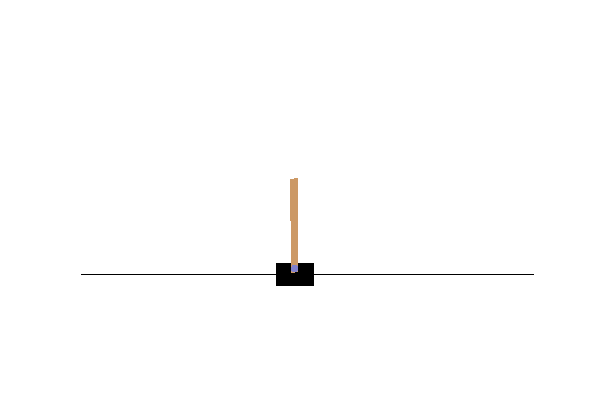
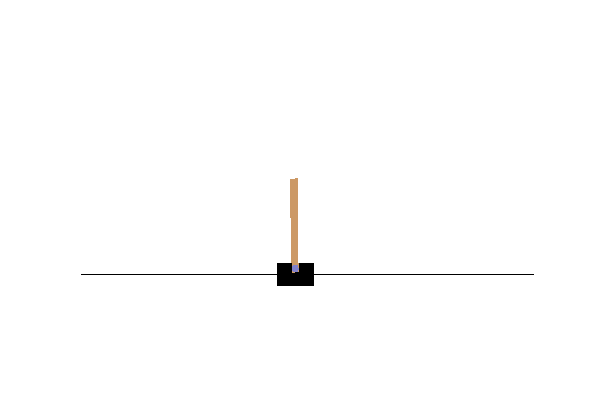
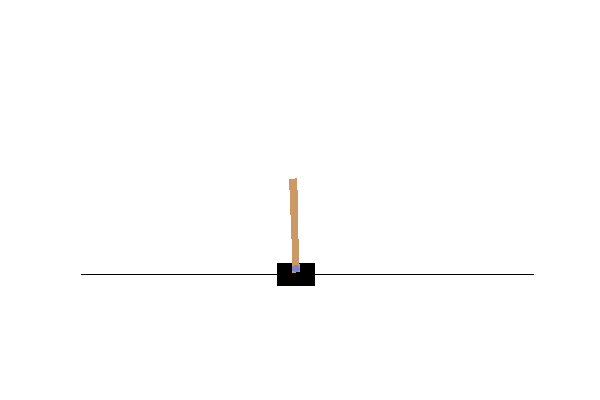
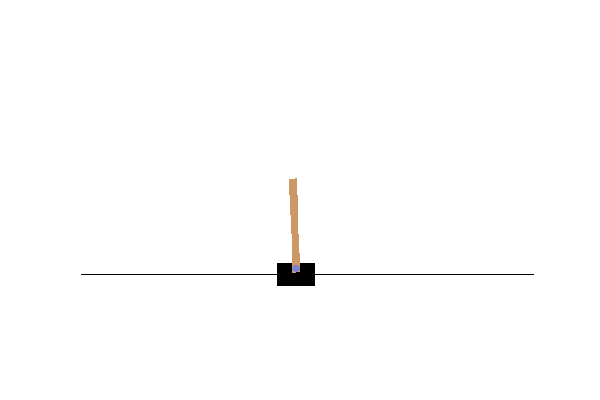
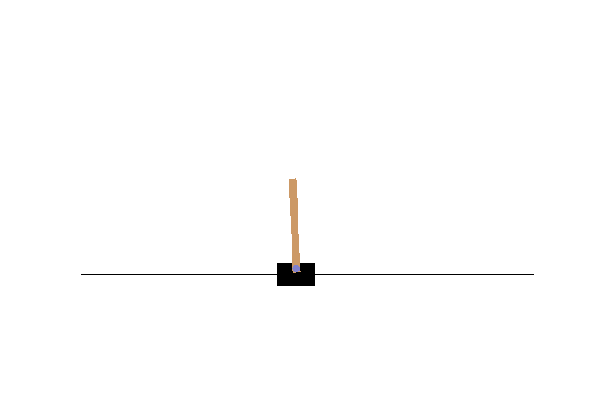
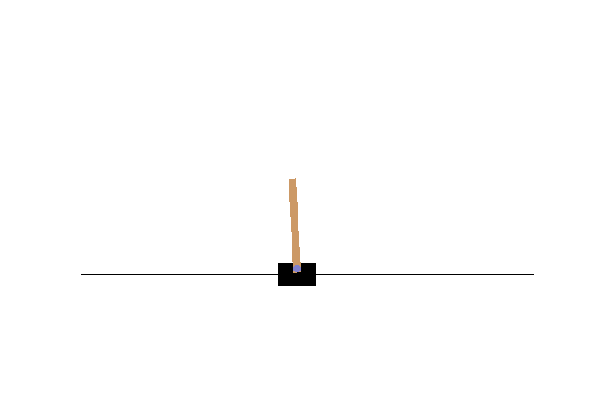
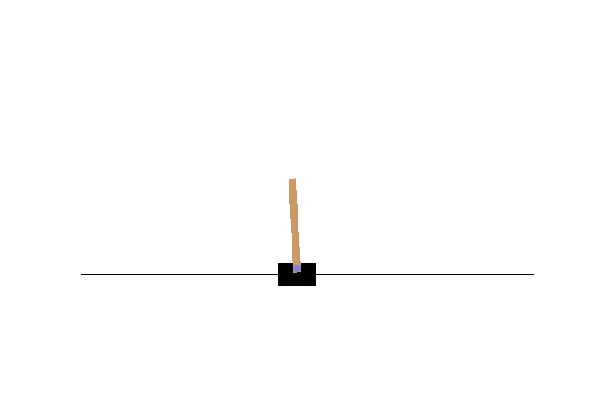
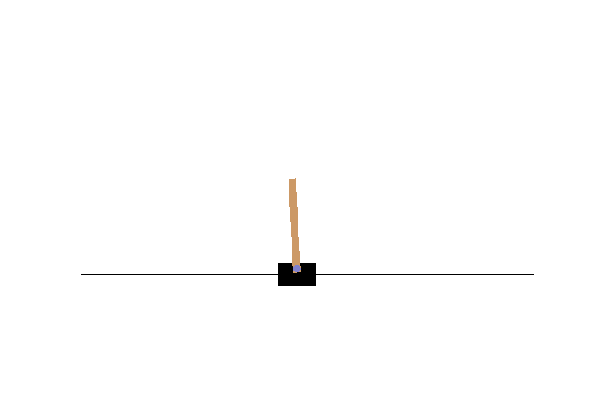
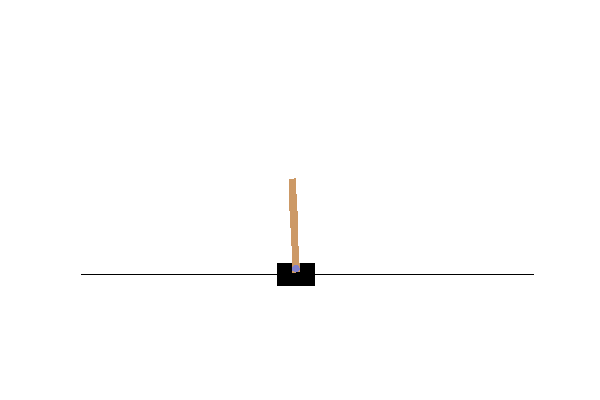
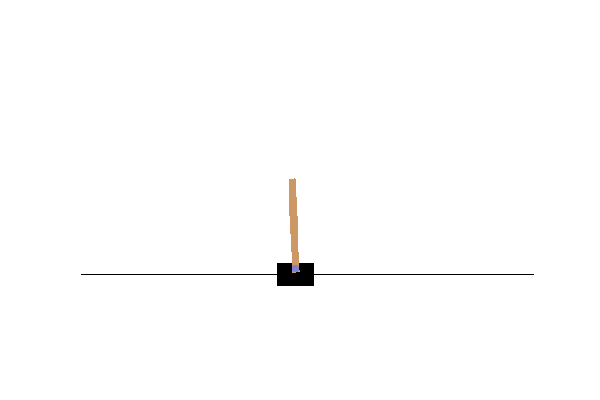
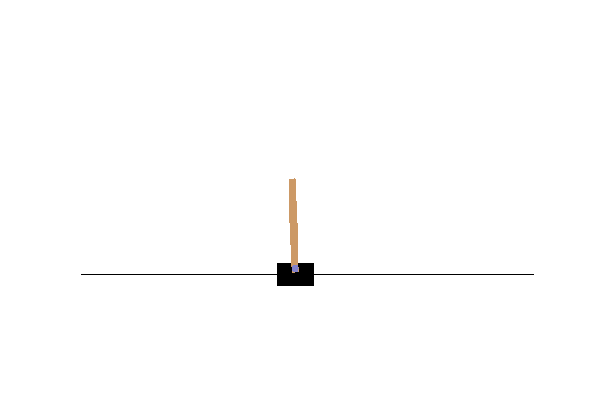
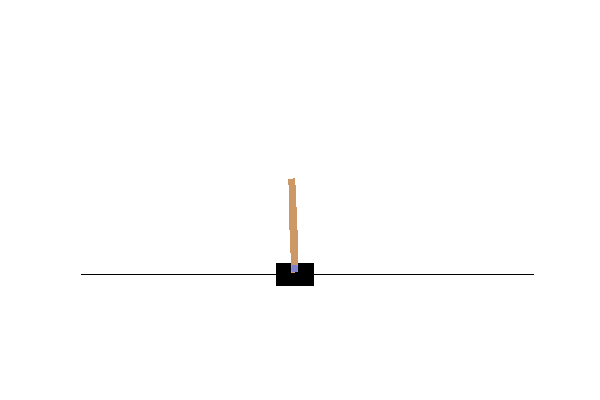
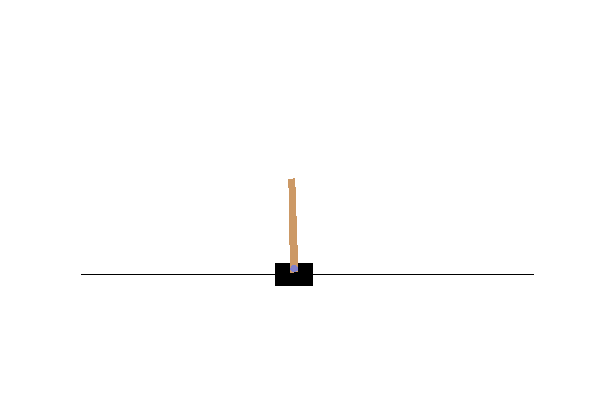
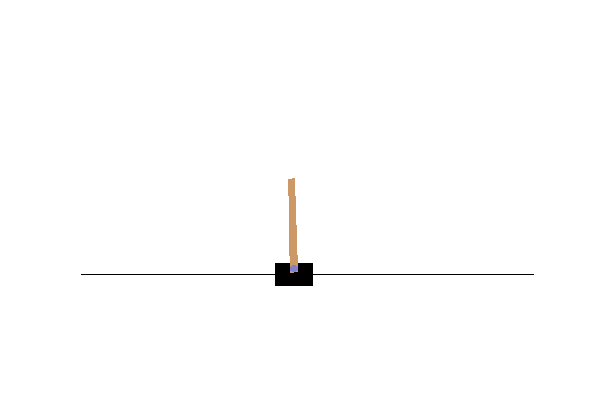
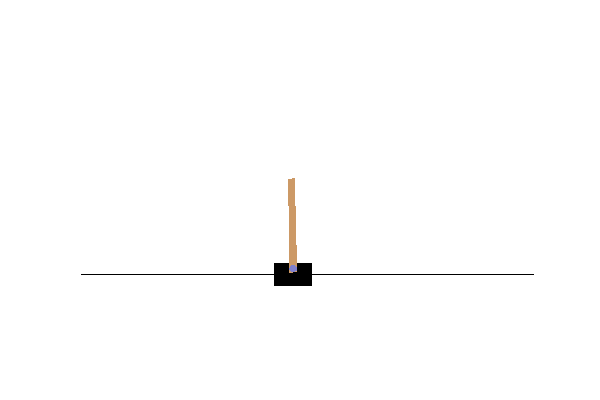
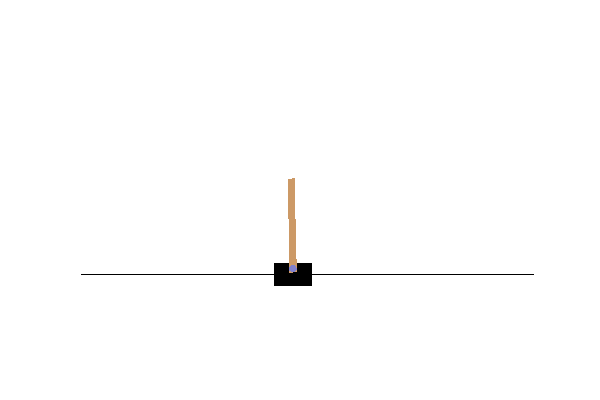
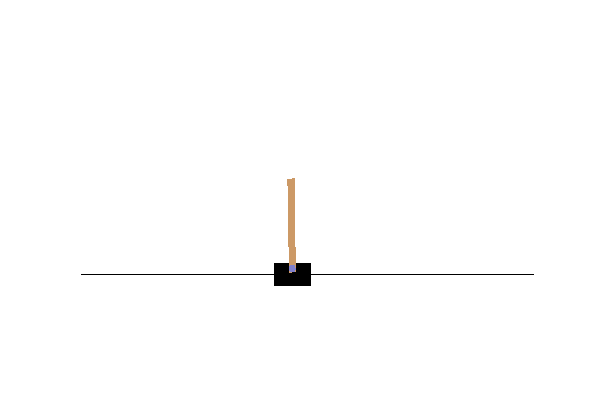
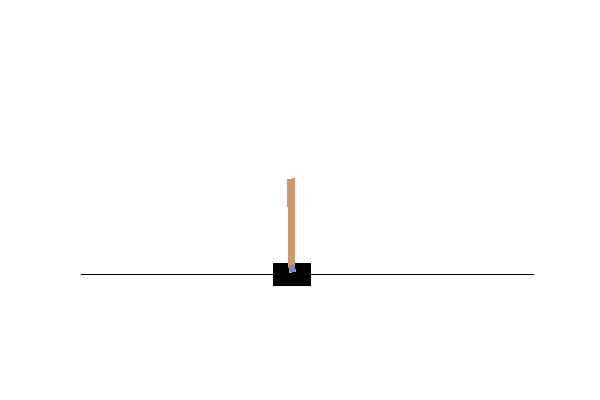
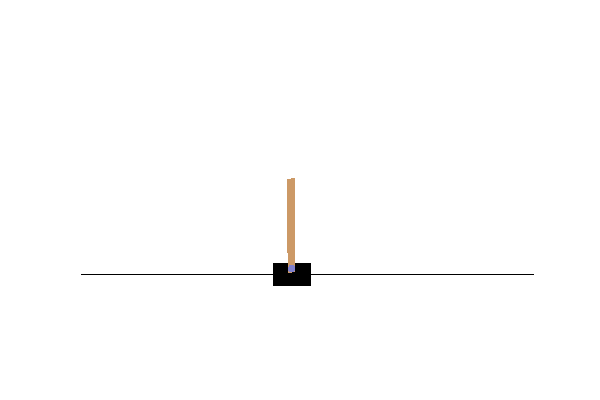
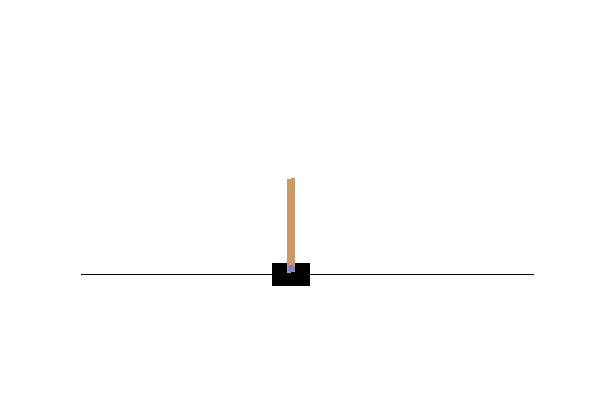
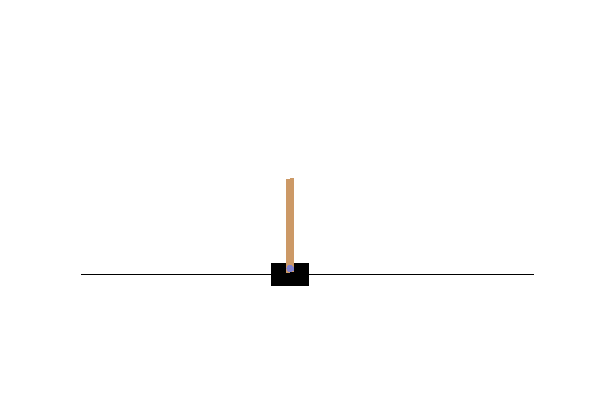
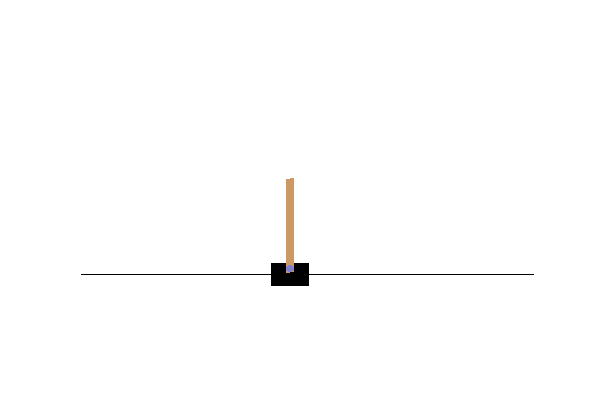
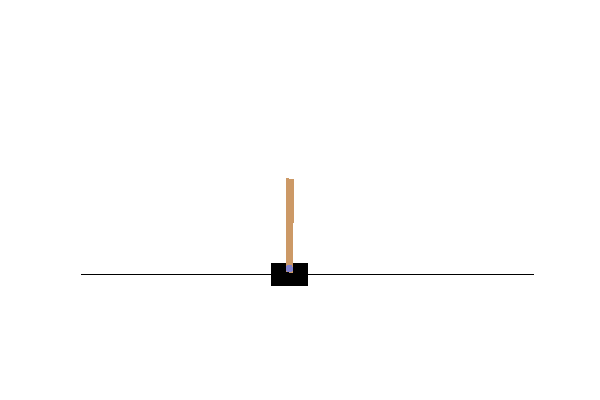
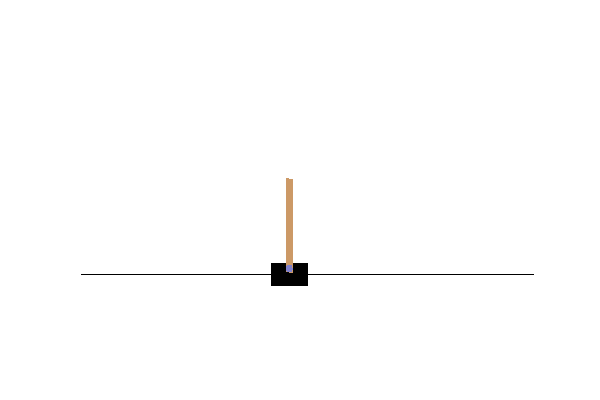
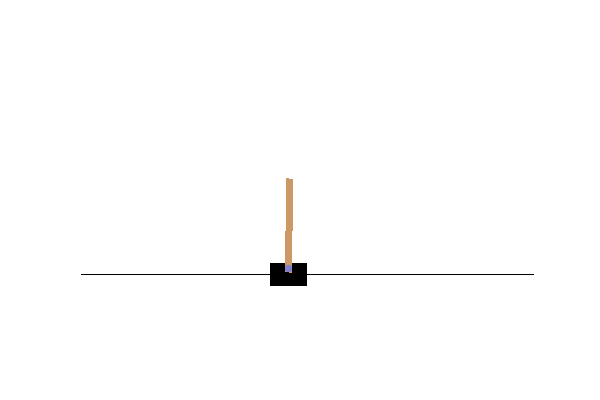
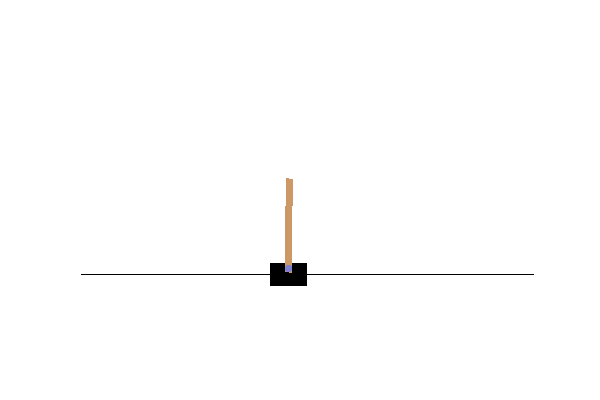
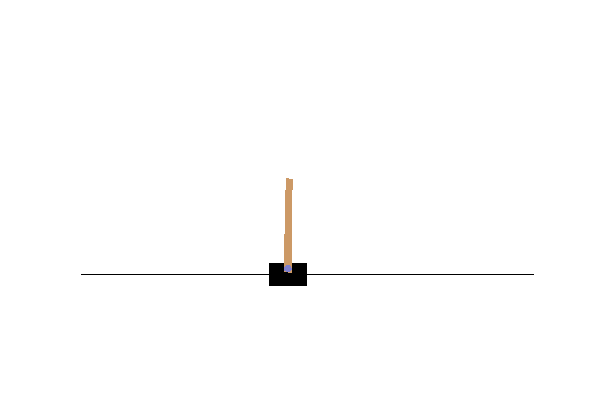
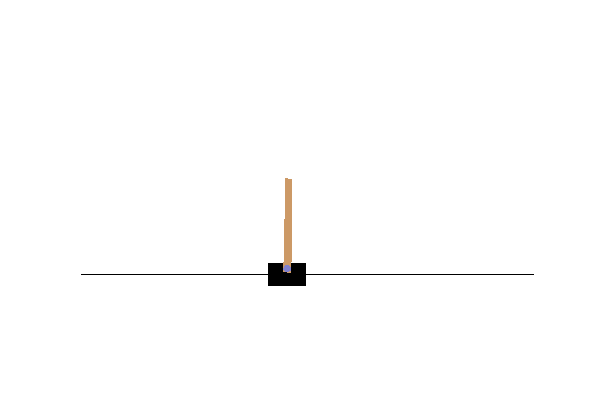
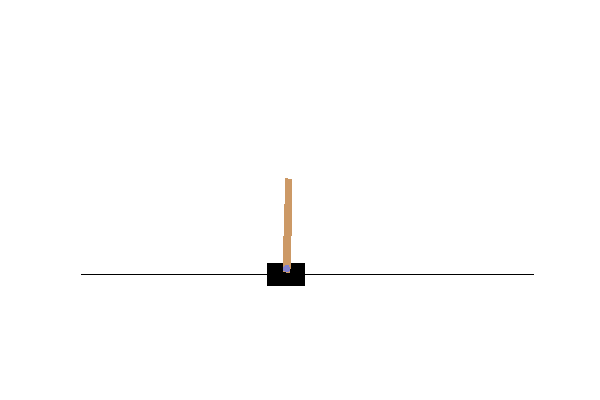
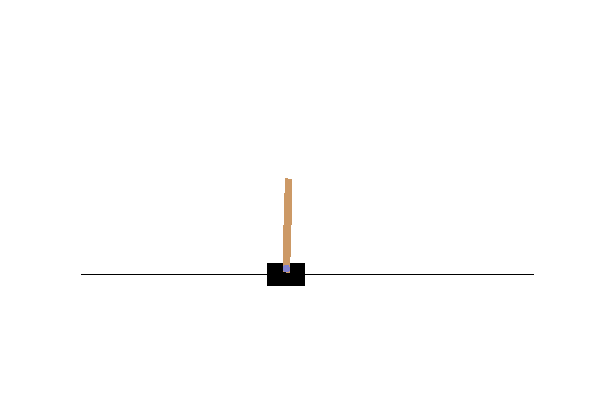
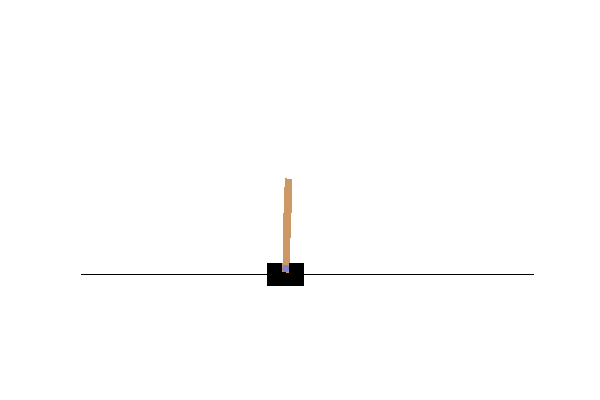
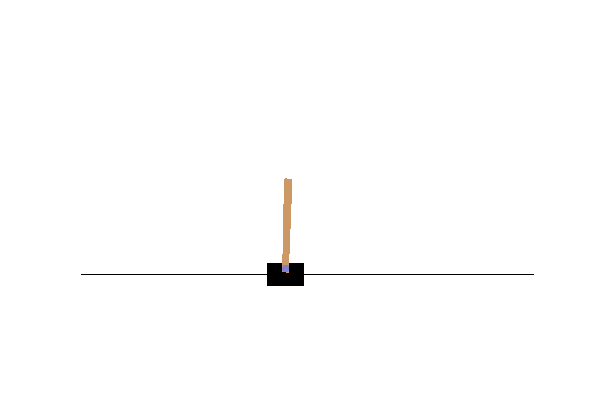
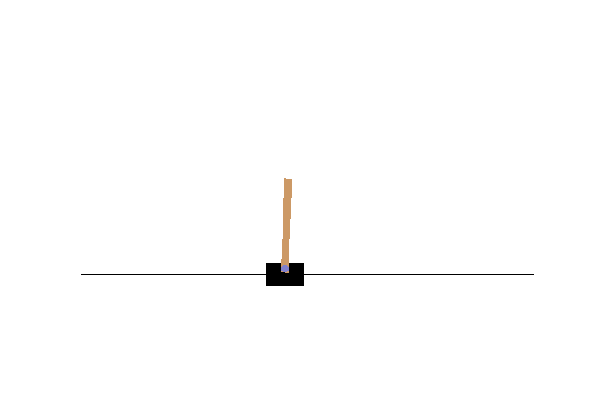
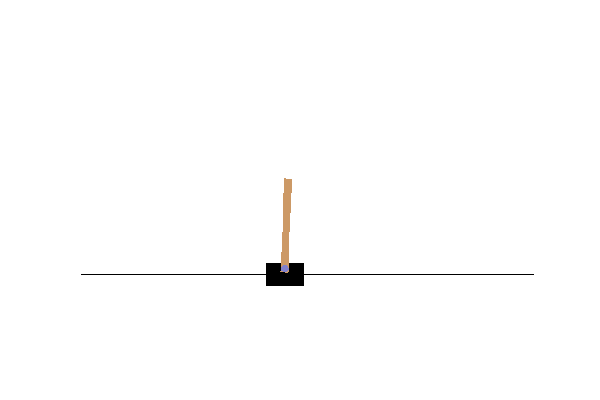
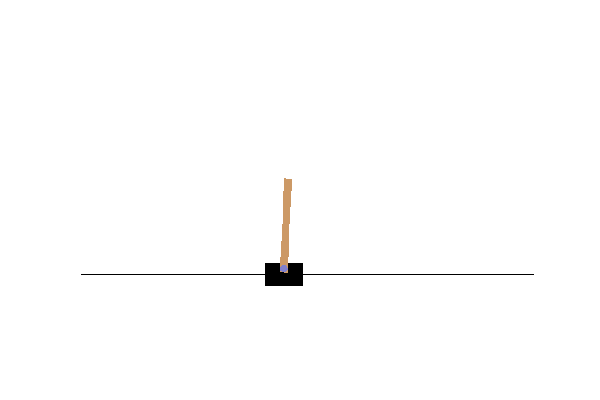
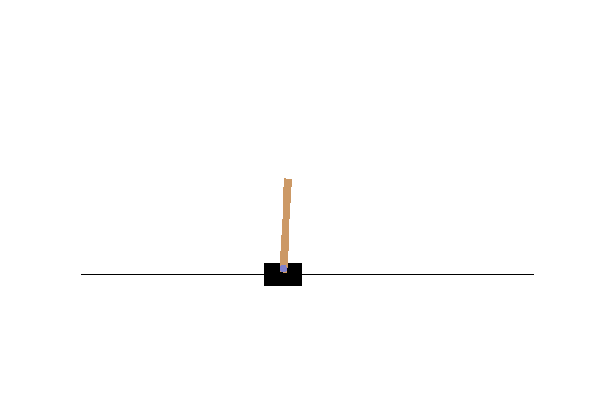
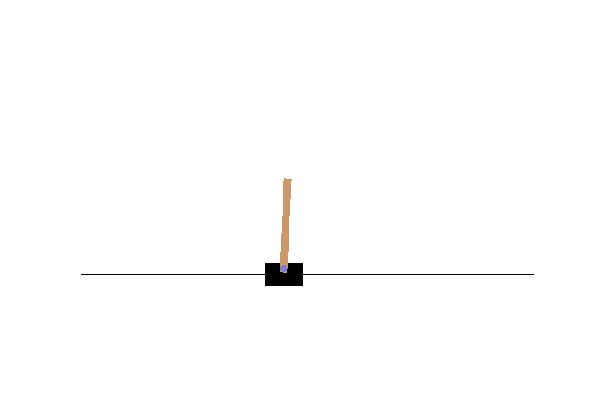
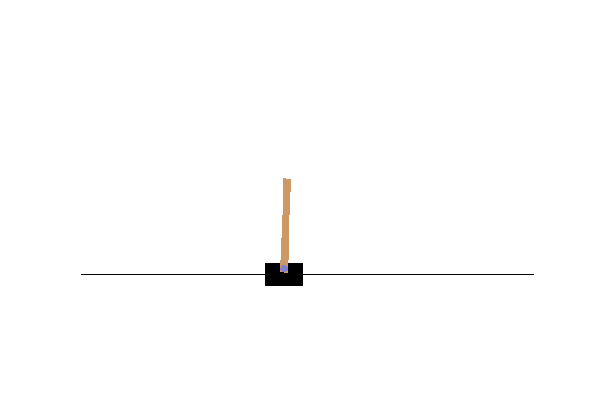
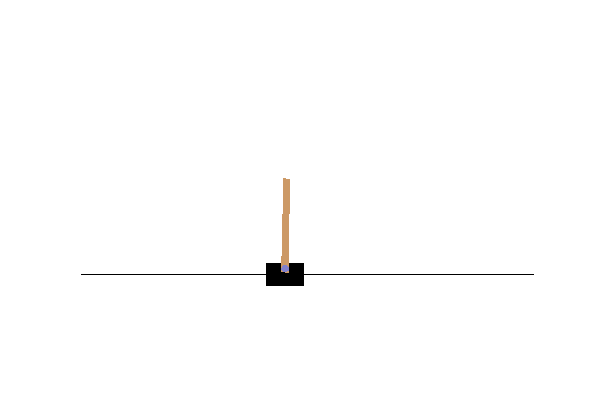
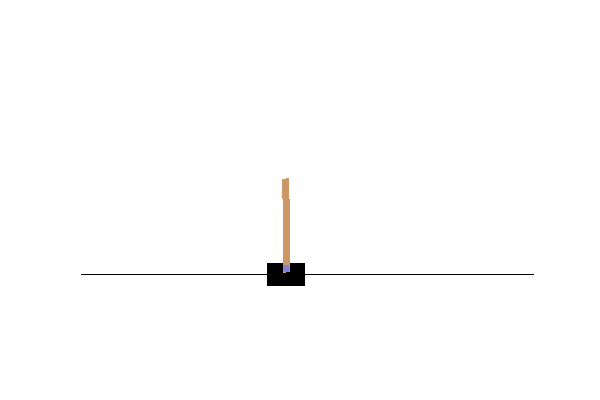
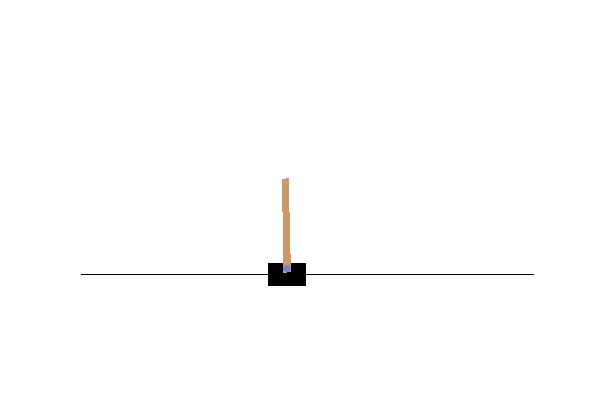
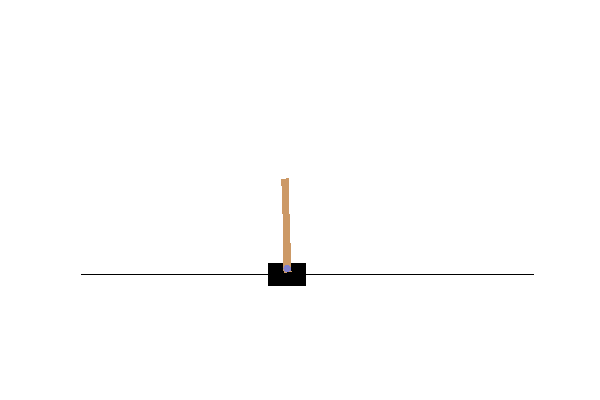
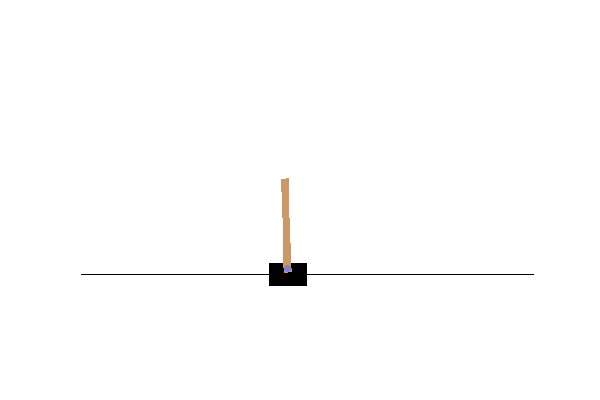
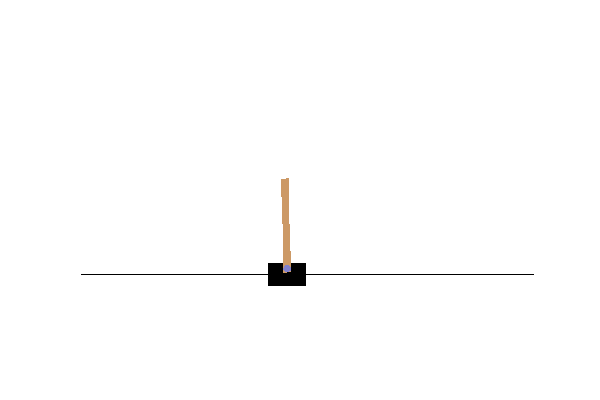
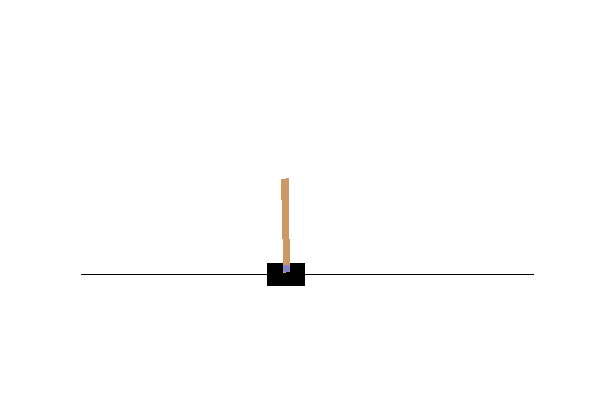
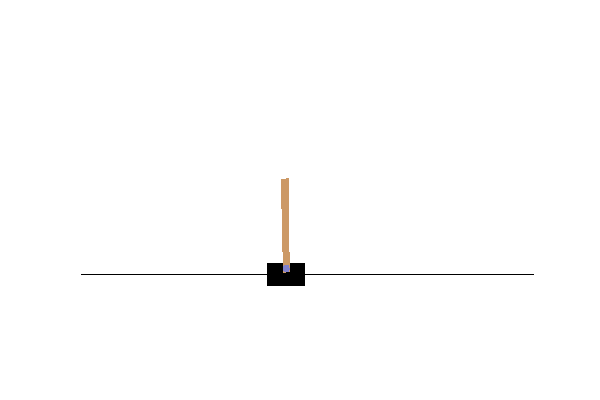
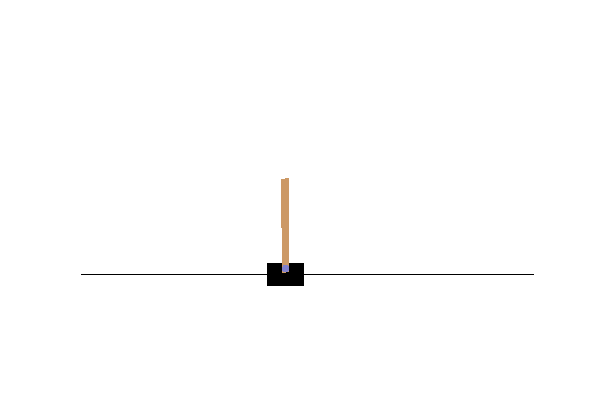
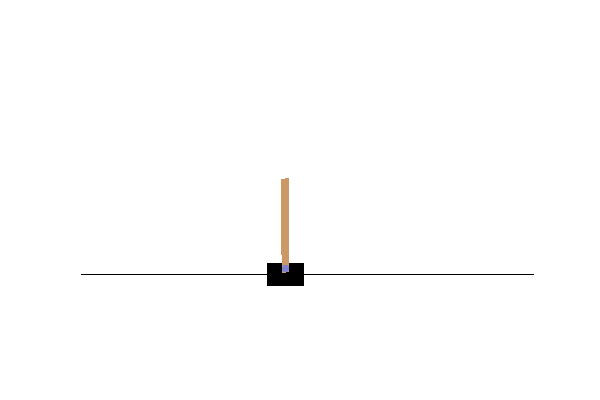
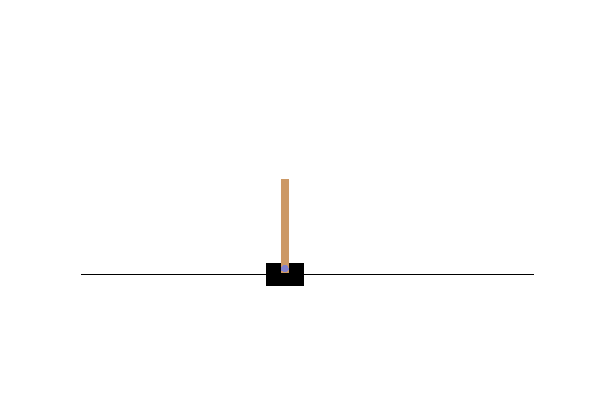
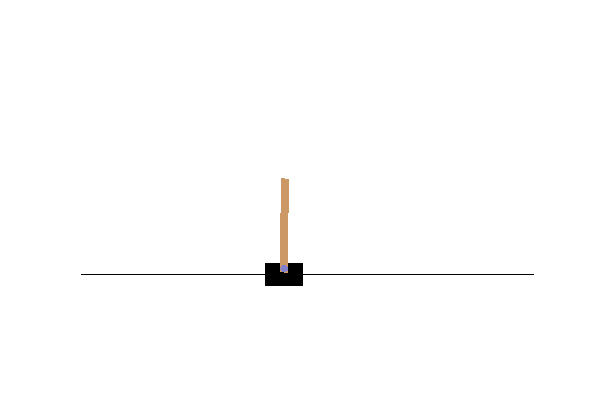
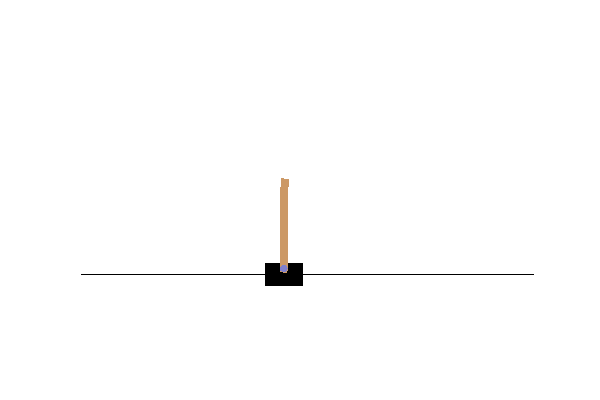
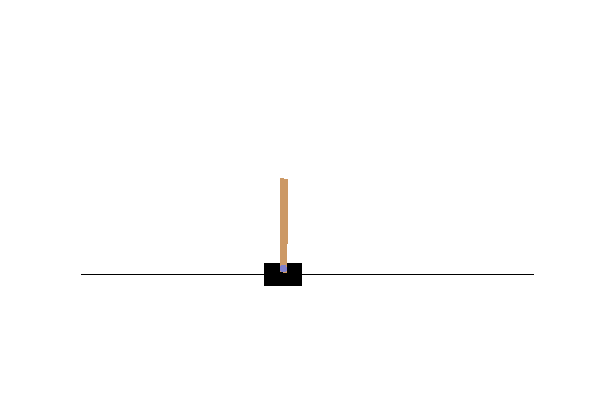
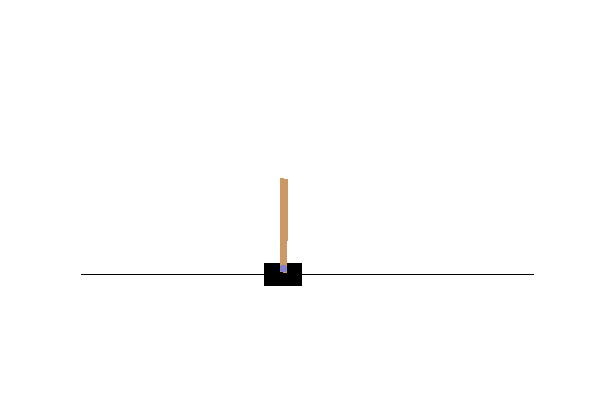
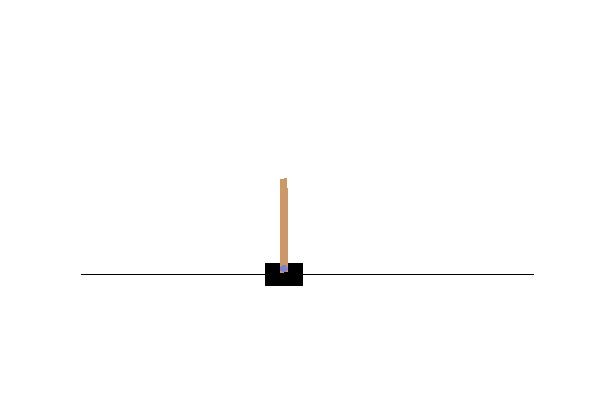
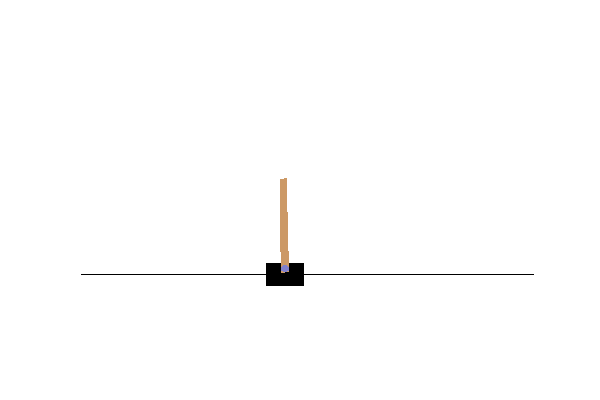
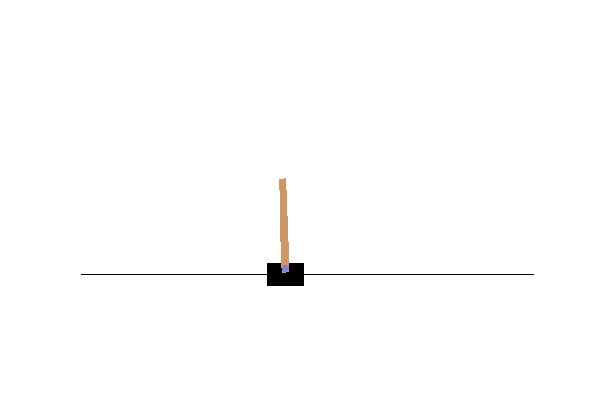
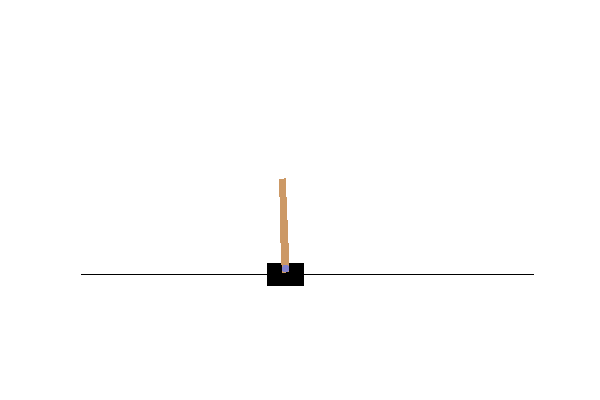
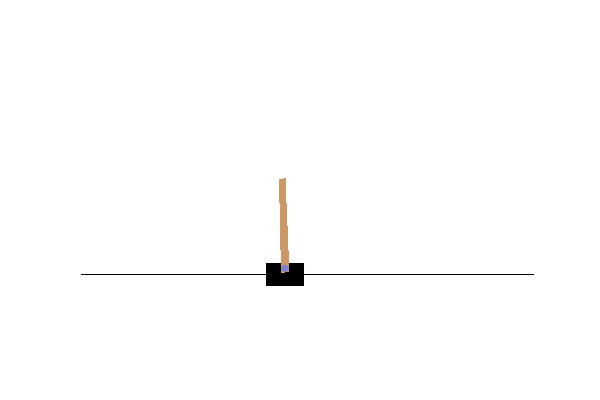
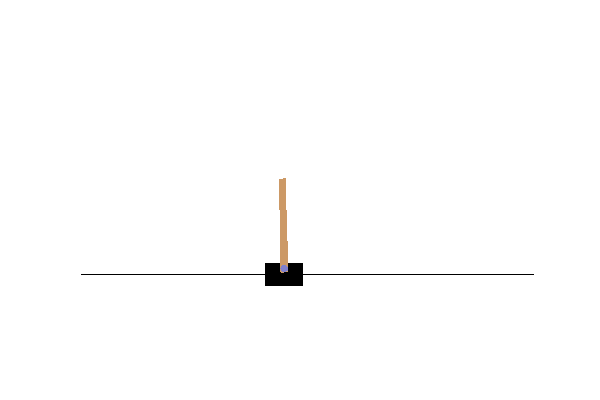
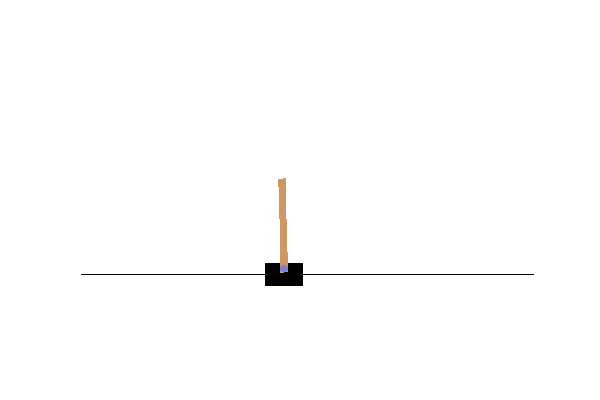
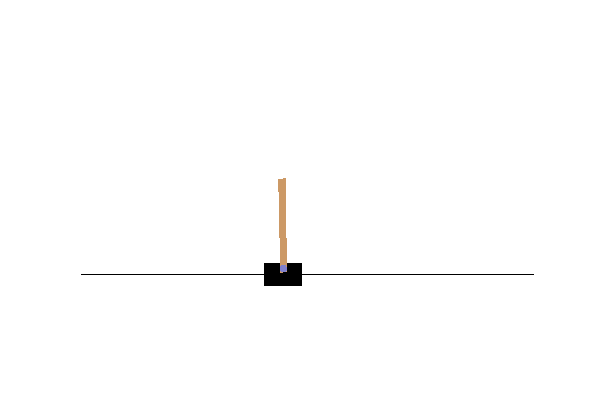
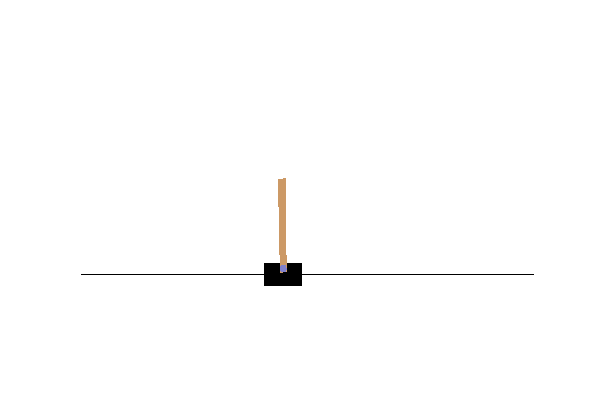
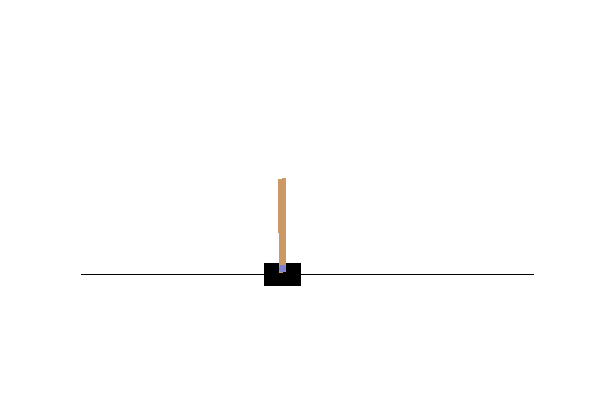

In [0]:
# JSAnimation 설치
!pip install JSAnimation

# 패키지 임포트
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display

# 애니메이션 재생 정의
def display_frames_as_gif(frames):
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    # 애니메이션 정기 처리
    def animate(i):
        patch.set_data(frames[i])
               
    # 애니메이션 재생
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))
    
# 애니메이션 재생
display_frames_as_gif(frames)